In [1]:
link = 'D:/users/Marko/downloads/mirna/'

# Imports

In [2]:
%load_ext tensorboard

In [3]:
import sys
#sys.path.insert(0,'/content/drive/MyDrive/Marko/master')
sys.path.insert(0, link)
import numpy as np
import matplotlib.pyplot as plt

#import tensorflow as tf

import torch
import torch.optim as optim
import torch.nn as nn
import torch.distributions as dist

from torch.nn import functional as F
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm
from tqdm import trange

import datetime


writer = SummaryWriter(f"{link}/saved_models/new/CIMVAE3/tensorboard")

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
DEVICE

device(type='cuda')

# Model Classes

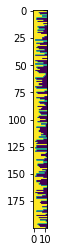

In [6]:
plt.imshow((torch.arange(13)[None, :] < torch.randint(2,14,(2,200))[:,:, None])[0])

In [7]:
stamp = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [1,0,0,0,0,0,0,0,0,0,0,0,0],
                   [1,1,0,0,0,0,0,0,0,0,0,0,0],
                   [1,1,1,0,0,0,0,0,0,0,0,0,0],
                   [1,1,1,1,0,0,0,0,0,0,0,0,0],
                   [1,1,1,1,1,0,0,0,0,0,0,0,0],
                   [1,1,1,1,1,1,0,0,0,0,0,0,0],
                   [1,1,1,1,1,1,1,0,0,0,0,0,0],
                   [1,1,1,1,1,1,1,1,0,0,0,0,0],
                   [1,1,1,1,1,1,1,1,1,0,0,0,0],
                   [1,1,1,1,1,1,1,1,1,1,0,0,0],
                   [1,1,1,1,1,1,1,1,1,1,1,0,0],
                   [1,1,1,1,1,1,1,1,1,1,1,1,0],
                   [1,1,1,1,1,1,1,1,1,1,1,1,1],
                 ])[None,:].to(DEVICE).float()

In [8]:
stamp.shape

torch.Size([1, 14, 13])

In [9]:
a = torch.arange(13)[None, :] < torch.randint(2,14,(64,200))[:,:, None]

In [10]:
torch.arange(13)[None, :].shape, torch.randint(2,14,(64,200))[:,:, None].shape

(torch.Size([1, 13]), torch.Size([64, 200, 1]))

In [11]:
tens1 = torch.tensor([[1.,0,0,0,0]])
tens2 = torch.tensor([[.9,0,0,0,0]])
tens3 = torch.tensor([[0.,0,0,0,0]])

In [12]:
print(F.cross_entropy(tens1, tens1, reduction='sum'))
print(F.cross_entropy(tens1, tens2, reduction='sum'))
print(F.cross_entropy(tens3, tens2, reduction='sum'))

tensor(0.9048)
tensor(0.8143)
tensor(1.4485)


In [13]:
a = a.reshape(-1,2,100,13)

In [14]:
b = a[:,0,:,:].flip(2)
c = torch.cat([b,a[:,1,:,:12]], 2).permute(0,2,1)[:,None].repeat(1,3,1,1)

In [15]:
d = torch.randint(0,2,(64,3,2,100))

In [16]:
e = d[:,:,0,None,:].repeat(1,1,13,1)
f = d[:,:,1,None,:].repeat(1,1,12,1)
g = torch.cat([e,f],2)

In [17]:
g.shape, c.shape

(torch.Size([64, 3, 25, 100]), torch.Size([64, 3, 25, 100]))

In [18]:
x = torch.tensor([[0.03,0.37,.1,0.4,0.1]])
y = torch.tensor([[0,0,0,0,0],
                 [1,0,0,0,0],
                 [1,1,0,0,0],
                 [1,1,1,0,0],
                 [1,1,1,1,1],
                 ])

In [19]:
x.shape, y.shape

(torch.Size([1, 5]), torch.Size([5, 5]))

In [20]:
x_test = F.one_hot(torch.randint(0,13,(64,200)), num_classes=13)
x_test.shape

torch.Size([64, 200, 13])

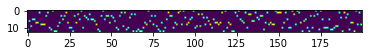

In [21]:
plt.imshow(x_test[0].T)

In [22]:
y_test = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0],
                       [1,0,0,0,0,0,0,0,0,0,0,0,0],
                       [1,1,0,0,0,0,0,0,0,0,0,0,0],
                       [1,1,1,0,0,0,0,0,0,0,0,0,0],
                       [1,1,1,1,1,0,0,0,0,0,0,0,0],
                       [1,1,1,1,1,1,0,0,0,0,0,0,0],
                       [1,1,1,1,1,1,1,0,0,0,0,0,0],
                       [1,1,1,1,1,1,1,1,0,0,0,0,0],
                       [1,1,1,1,1,1,1,1,1,0,0,0,0],
                       [1,1,1,1,1,1,1,1,1,1,0,0,0],
                       [1,1,1,1,1,1,1,1,1,1,1,0,0],
                       [1,1,1,1,1,1,1,1,1,1,1,1,0],
                       [1,1,1,1,1,1,1,1,1,1,1,1,1],
                 ])[None,:].repeat(64,1,1)
y_test.shape

torch.Size([64, 13, 13])

In [23]:
tst = torch.bmm(x_test,y_test)
tst.shape

torch.Size([64, 200, 13])

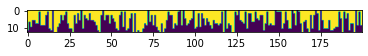

In [24]:
plt.imshow(tst[0].T)

In [25]:
x2 = torch.randint(0,2,(64,200,13))
y2 = torch.ones((64,13,13))

In [26]:
x2.T.shape

D:\Users\Marko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2318.)
  """Entry point for launching an IPython kernel.


torch.Size([13, 200, 64])

In [27]:
#torch.bmm(x2,y2).shape

In [28]:
im = c*g+(~c)

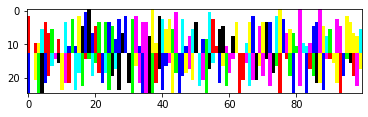

In [29]:
plt.imshow((im[0].permute(1,2,0)*255))

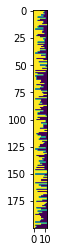

In [30]:
plt.imshow((torch.arange(13)[None, :] < torch.randint(2,14,(2,200))[:,:, None])[1])

In [31]:
torch.arange(13)[None, :].shape , torch.randint(2,14,(64,200))[:, :, None].shape

(torch.Size([1, 13]), torch.Size([64, 200, 1]))

In [32]:
class diva_args:

    def __init__(self, z_dim=128, d_dim=45, x_dim=7500, y_dim=2,
                 beta=1, rec = 1,
                 warmup = 1, prewarmup = 1):

        self.z_dim = z_dim
        self.d_dim = d_dim
        self.x_dim = x_dim
        self.y_dim = y_dim
        
        self.beta = beta
        self.rec = rec
        self.warmup = warmup
        self.prewarmup = prewarmup


## Dataset Class

In [33]:
class MicroRNADataset(Dataset):

    def __init__(self, ds='train', create_encodings=False, use_subset=False):
        
        # loading images
        self.images = np.load(f'{link}/data/modmirbase_{ds}_images.npz')['arr_0']/255
        
        
        if create_encodings:
            x_cat = self.get_encoded_values(self.images, ds)
        else:
            x_cat = np.load(f'{link}/data/modmirbase_{ds}_images_cattt.npz')['arr_0']
        #self.images_cat = np.load(f'{link}/data/modmirbase_{ds}_images_cat_new.npz')
        
        self.images_cat = x_cat
        
        # loading labels
        print('Loading Labels! (~10s)')     
        ohe = OneHotEncoder(categories='auto', sparse=False)
        labels = np.load(f'{link}/data/modmirbase_{ds}_labels.npz')['arr_0']
        self.labels = ohe.fit_transform(labels)
        
        
        self.mountain = np.load(f'{link}/data/modmirbase_{ds}_mountain.npy')
        
        
        # loading names
        print('Loading Names! (~5s)')
        names =  np.load(f'{link}/data/modmirbase_{ds}_names.npz')['arr_0']
        names = [i.decode('utf-8') for i in names]
        self.species = ['mmu', 'prd', 'hsa', 'ptr', 'efu', 'cbn', 'gma', 'pma',
                        'cel', 'gga', 'ipu', 'ptc', 'mdo', 'cgr', 'bta', 'cin', 
                        'ppy', 'ssc', 'ath', 'cfa', 'osa', 'mtr', 'gra', 'mml',
                        'stu', 'bdi', 'rno', 'oan', 'dre', 'aca', 'eca', 'chi',
                        'bmo', 'ggo', 'aly', 'dps', 'mdm', 'ame', 'ppc', 'ssa',
                        'ppt', 'tca', 'dme', 'sbi']
        # assigning a species label to each observation from species
        # with more than 200 observations from past research
        self.names = []
        for i in names:
            append = False
            for j in self.species:
                if j in i.lower():
                    self.names.append(j)
                    append = True
                    break
            if not append:
                if 'random' in i.lower() or i.isdigit():
                    self.names.append('hsa')
                else:
                    self.names.append('notfound')
        
        # performing one hot encoding
        ohe = OneHotEncoder(categories='auto', sparse=False)
        
       
        
        self.names_ohe = ohe.fit_transform(np.array(self.names).reshape(-1,1))
            
    def __len__(self):
        return(self.images.shape[0])

    def __getitem__(self, idx):
        d = self.names_ohe[idx]
        y = self.labels[idx]
        x = self.images[idx]
        x = np.transpose(x, (2,0,1))
        x_cat = self.images_cat[idx]
        return (x_cat, y, d, x)


    def get_encoded_values(self, x, ds):
        """
        given an image or batch of images
        returns length of strand, length of bars and colors of bars
        """
        n = x.shape[0]
        x = np.transpose(x, (0,3,1,2))
        x_cat = np.zeros((n, 5, 25, 100), dtype=np.uint8)
        
        for i in range(n):
            if i % 100 == 0:
                print(f'at {i} out of {n}')
            for j in range(100):
                if (x[i,:,12,j] == np.array([1,1,1])).all():
                    break
                else:
                    # loop through all pixels of the bar
                    for k in range(25):
                        if (x[i,:,k,j] == np.array([1,1,1])).all():
                            continue
                        else:
                            x_cat[i,self.get_color(x[i,:,k,j]),k,j] = 1

        np.savez_compressed(f'{link}/data/modmirbase_{ds}_images_cattt.npz', x_cat)
        #with open(f'{link}/data/modmirbase_{ds}_images_cattt.npz', 'wb') as f:
        #    np.save(f, out_len)
        

        return x_cat

        
    
    def get_color(self, pixel):
        """
        returns the encoded value for a pixel
        """
        if (pixel == np.array([0,0,0])).all():  
            return 0 # black
        elif (pixel == np.array([1,0,0])).all():  
            return 1 # red
        elif (pixel == np.array([0,0,1])).all():  
            return 2 # blue
        elif (pixel == np.array([0,1,0])).all():  
            return 3 # green
        elif (pixel == np.array([1,1,0])).all():  
            return 4 # yellow
        else:
            print("Something wrong!")


## Decoder classes

In [34]:
# Decoders
class px(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, z_dim, dim1=256, dim2=500):
        super(px, self).__init__()

        self.fc = nn.Sequential(nn.Linear(z_dim, dim2),  
                                nn.ReLU(),
                                nn.Dropout(.1),
                                nn.Linear(dim2, dim2),
                                nn.Dropout(.2),
                                nn.ReLU())
        
        # Predicting length and color of each bar
        
        self.color = nn.Sequential(nn.Linear(dim2, 1000))
        
        self.bars = nn.Sequential(nn.ConvTranspose2d(5,32, kernel_size=3,stride=5,padding=0),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(32,64,kernel_size=3,stride=1,padding=1),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(64,64,kernel_size=3,stride=1,padding=1),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(64,128,kernel_size=3,stride=1,padding=1),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(128,128,kernel_size=3,stride=1,padding=1),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(128,1,kernel_size=3,stride=1,padding=0),
                                        )
        
        
        
    def forward(self, z):
        
        h = self.fc(z)
        len_bar = h.reshape(-1,5,5,20)
        bars = self.bars(len_bar)
        bars_t = nn.Softmax(dim=1)(bars[:,:,:13,:]).cumsum(2)    #.repeat(1,5,1,1)
        bars_b = nn.Softmax(dim=1)(bars[:,:,13:,:]).flip(2).cumsum(2).flip(2)
        
        bars = torch.cat([bars_t, bars_b], 2)
        
        
        
        
        col = nn.Softmax(dim=1)(self.color(h).reshape(-1,5,2,100))
        col_top = col[:,:,0,None,:].repeat(1,1,13,1)
        col_bot = col[:,:,1,None,:].repeat(1,1,12,1)
        color = torch.cat([col_top,col_bot],2)
        
        rna = color*bars
        
        return rna, col, bars
    
    def sample(self, color, len_bar, mean=True):
        
        if mean:
            bars = torch.round(len_bar)[:,:3]
            #bars = torch.where(bars>0, bars+1, bars)
            col_ = torch.argmax(color, dim=1)
        else:
            bars = dist.Bernoulli(len_bar).sample()
            #bars = torch.where(bars>0, bars+1, bars)
            col_ = dist.Categorical(color).sample()
        
        
        col = torch.zeros((col_.shape[0],3,col_.shape[1],col_.shape[2])).to(DEVICE)
        
        for i in range(col_.shape[0]):
            for j in range(col_.shape[1]):
                for k in range(col_.shape[2]):
                    col[i,:,j,k] = self.get_color(col_[i,j,k])
        
        col_top = col[:,:,0,None,:].repeat(1,1,13,1)
        col_bot = col[:,:,1,None,:].repeat(1,1,12,1)
        color = torch.cat([col_top,col_bot],2)
        
        
        rna = color*bars
        
         
                
        return rna.permute(0,2,3,1)
                
                

                
    def get_color(self, color):
        if color == 0:
            return torch.tensor([0,0,0])
        elif color == 1:
            return torch.tensor([1,0,0])
        elif color == 2:
            return torch.tensor([0,0,1])
        elif color == 3:
            return torch.tensor([0,1,0])
        elif color == 4:
            return torch.tensor([1,1,0])
        

In [35]:
int(np.round(3.7, 0))
int(3.7)

3

In [36]:
# pzy_ = pzy(45, 7500, 2, 32,32,32)
# summary(pzy_, (1,2))
pzy_ = px(45, 7500, 2, 512)
summary(pzy_, (1,512))

Layer (type:depth-idx)                   Output Shape              Param #
px                                       --                        --
├─Sequential: 1-1                        [1, 500]                  --
│    └─Linear: 2-1                       [1, 500]                  256,500
│    └─ReLU: 2-2                         [1, 500]                  --
│    └─Dropout: 2-3                      [1, 500]                  --
│    └─Linear: 2-4                       [1, 500]                  250,500
│    └─Dropout: 2-5                      [1, 500]                  --
│    └─ReLU: 2-6                         [1, 500]                  --
├─Sequential: 1-2                        [1, 1, 25, 100]           --
│    └─ConvTranspose2d: 2-7              [1, 32, 23, 98]           1,472
│    └─ReLU: 2-8                         [1, 32, 23, 98]           --
│    └─ConvTranspose2d: 2-9              [1, 64, 23, 98]           18,496
│    └─ReLU: 2-10                        [1, 64, 23, 98]           -

## Endcoder Classes

In [37]:
#pzy_.reconstruct_image(torch.zeros((1,100)), torch.zeros((1,13,200)), torch.zeros(1,5,200)).shape

In [38]:
class qz(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, z_dim, h_dim=2592):
        super(qz, self).__init__()
        self.h_dim = h_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 48, kernel_size=5, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=5, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(48, 60, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(60, 60, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(60, 72, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(), 
            nn.Conv2d(72, 72, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),
        )

        self.fc11 = nn.Sequential(nn.Linear(self.h_dim, z_dim))
        self.fc12 = nn.Sequential(nn.Linear(self.h_dim, z_dim), nn.Softplus())


    def forward(self, x):
        h = self.encoder(x)
        h = h.view(-1, self.h_dim)
        z_loc = self.fc11(h)
        z_scale = self.fc12(h) + 1e-7

        return z_loc, z_scale




In [39]:
enc = qz(128,10,10,512)
summary(enc, (1,5,25,100))

Layer (type:depth-idx)                   Output Shape              Param #
qz                                       --                        --
├─Sequential: 1-1                        [1, 72, 3, 12]            --
│    └─Conv2d: 2-1                       [1, 48, 25, 100]          6,048
│    └─ReLU: 2-2                         [1, 48, 25, 100]          --
│    └─Conv2d: 2-3                       [1, 48, 25, 100]          57,648
│    └─ReLU: 2-4                         [1, 48, 25, 100]          --
│    └─MaxPool2d: 2-5                    [1, 48, 12, 50]           --
│    └─Conv2d: 2-6                       [1, 60, 12, 50]           25,980
│    └─ReLU: 2-7                         [1, 60, 12, 50]           --
│    └─Conv2d: 2-8                       [1, 60, 12, 50]           32,460
│    └─ReLU: 2-9                         [1, 60, 12, 50]           --
│    └─MaxPool2d: 2-10                   [1, 60, 6, 25]            --
│    └─Conv2d: 2-11                      [1, 72, 6, 25]            38,

## Full model class

In [40]:
class StampDIVA(nn.Module):
    def __init__(self, args):
        super(StampDIVA, self).__init__()
        self.z_dim = args.z_dim
        self.d_dim = args.d_dim
        self.x_dim = args.x_dim
        self.y_dim = args.y_dim

        self.px = px(self.d_dim, self.x_dim, self.y_dim, self.z_dim)
        
        self.qz = qz(self.d_dim, self.x_dim, self.y_dim, self.z_dim)
        

        self.beta = args.beta
        
        self.rec = args.rec
        self.warmup = args.warmup
        self.prewarmup = args.prewarmup

        self.cuda()

    def forward(self, d, x, y):
        # Encode
        zd_q_loc, zd_q_scale = self.qz(x)
        
        # Reparameterization trick
        qz = dist.Normal(zd_q_loc, zd_q_scale)
        z_q = qz.rsample()
        
        
        # Decode
        x_hat, color, bars = self.px(z_q)
        z_p_loc, z_p_scale = torch.zeros(z_q.size()[0], self.z_dim).cuda(),\
                        torch.ones(z_q.size()[0], self.z_dim).cuda()
        
        pz = dist.Normal(z_p_loc, z_p_scale)
        
        return x_hat, qz, pz, z_q, color ,bars

    def loss_function(self, d, x, y):
        
        x_hat, qz, pz, z_q, _, _ = self.forward(d, x, y)
       
        rec_loss = F.mse_loss(x_hat, x, reduction='sum')
        
        KL_z = torch.sum(pz.log_prob(z_q) - qz.log_prob(z_q))
          
        return self.rec * rec_loss - self.beta * KL_z, rec_loss

In [41]:
default_args = diva_args(z_dim=256, rec = 10, 
                         beta=1, warmup=1, prewarmup=0)
enc = StampDIVA(default_args)
summary(enc,[ (1,1),(1,5,25,100),(1,1)])

Layer (type:depth-idx)                   Output Shape              Param #
StampDIVA                                --                        --
├─qz: 1-1                                [1, 256]                  --
│    └─Sequential: 2-1                   [1, 72, 3, 12]            --
│    │    └─Conv2d: 3-1                  [1, 48, 25, 100]          6,048
│    │    └─ReLU: 3-2                    [1, 48, 25, 100]          --
│    │    └─Conv2d: 3-3                  [1, 48, 25, 100]          57,648
│    │    └─ReLU: 3-4                    [1, 48, 25, 100]          --
│    │    └─MaxPool2d: 3-5               [1, 48, 12, 50]           --
│    │    └─Conv2d: 3-6                  [1, 60, 12, 50]           25,980
│    │    └─ReLU: 3-7                    [1, 60, 12, 50]           --
│    │    └─Conv2d: 3-8                  [1, 60, 12, 50]           32,460
│    │    └─ReLU: 3-9                    [1, 60, 12, 50]           --
│    │    └─MaxPool2d: 3-10              [1, 60, 6, 25]            --


# Training the model

## Loading dataset

In [42]:
RNA_dataset = MicroRNADataset(create_encodings=False)

Loading Labels! (~10s)
Loading Names! (~5s)


In [43]:
RNA_dataset_test = MicroRNADataset('test', create_encodings=False)

Loading Labels! (~10s)
Loading Names! (~5s)


In [44]:
len(RNA_dataset)

34721

In [45]:
def train_single_epoch(train_loader, model, optimizer, epoch):
    model.train()
    train_loss = 0
    no_batches = 0
    mse_t = 0
    pbar = tqdm(enumerate(train_loader), unit="batch", 
                                     desc=f'Epoch {epoch}')
    for batch_idx, (x, y, d, _) in pbar:
        # To device
        x, y, d = x.to(DEVICE), y.to(DEVICE), d.to(DEVICE)

        optimizer.zero_grad()
        loss, mse = model.loss_function(d.float(), x.float(), y.float())
      
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item()/x.shape[0])
        train_loss += loss
        mse_t += mse
        no_batches += 1

    train_loss /= len(train_loader.dataset)
    mse_t /= len(train_loader.dataset)
    
    return train_loss, mse_t

In [46]:
def test_single_epoch(test_loader, model, epoch):
    model.eval()
    test_loss = 0
    mse_t = 0
    with torch.no_grad():
        for batch_idx, (x,y,d,_) in enumerate(test_loader):
            x, y, d= x.to(DEVICE), y.to(DEVICE), d.to(DEVICE)
            loss , mse = model.loss_function(d.float(), x.float(), y.float())
            test_loss += loss
            mse_t += mse
            
    test_loss /= len(test_loader.dataset)
    mse_t /= len(test_loader.dataset)
    
    return test_loss, mse_t
  

In [47]:
def train(args, train_loader, test_loader, diva, optimizer, end_epoch, start_epoch=0, save_folder='sd_1.0.0',save_interval=5):
    
    epoch_loss_sup = []
    test_loss = []
    
    for epoch in range(start_epoch+1, end_epoch+1):
        #idx1, idx2 = choose_index(epoch)
        diva.beta = min([args.beta, args.beta * (epoch - args.prewarmup * 1.) / (args.warmup)])
        if epoch< args.prewarmup:
            diva.beta = args.beta/args.prewarmup
        train_loss , mtr = train_single_epoch(train_loader, diva, optimizer, epoch)
        str_loss_sup = train_loss
        epoch_loss_sup.append(train_loss)
        str_print = "epoch {}: avg train loss {:.2f}".format(epoch, str_loss_sup)
        str_print += ", ce {:.3f}".format(mtr)
        print(str_print)

        rec_loss_train = diva.rec * mtr
        dis_loss_train = train_loss - rec_loss_train

        test_lss, mte = test_single_epoch(test_loader, diva, epoch)
        test_loss.append(test_lss)
       
        str_print = "epoch {}: avg test  loss {:.2f}".format(epoch, test_lss)
        str_print += ", ce {:.3f}".format(mte)
        print(str_print)

        rec_loss_test = diva.rec* mte
        dis_loss_test = test_lss - rec_loss_test

        if writer is not None:
            
            writer.add_scalars("Total_Loss", {'train': train_loss, 'test': test_lss} ,epoch)
            writer.add_scalars("Reconstruction_vs_Disentanglement",{'rec':rec_loss_train, 'dis':dis_loss_train}, epoch)
            writer.add_scalars("bar_mse",{'train': mtr, 'test':mte}, epoch)
           
        if epoch % save_interval == 0:
            save_reconstructions(epoch, test_loader, diva, name=save_folder)
            save_reconstructions(epoch, train_loader, diva, name=save_folder, estr='tr')
        
        
        if epoch % 50 == 0:
            torch.save(diva.state_dict(), f'{link}/saved_models/{save_folder}/checkpoints/{epoch}.pth')

    if writer is not None:
        writer.flush()

    epoch_loss_sup = [i.detach().cpu().numpy() for i in epoch_loss_sup]
    test_loss = [i.detach().cpu().numpy() for i in test_loss]
    return epoch_loss_sup, test_loss

In [48]:
def save_reconstructions(epoch, test_loader, diva, name='diva', estr=''):
    a = next(enumerate(test_loader))
    with torch.no_grad():
        diva.eval()
        d = a[1][2][:10].to(DEVICE).float()
        x = a[1][0][:10].to(DEVICE).float()
        y = a[1][1][:10].to(DEVICE).float()
        x_org = a[1][-1][:10]
        x_hat ,qz, pz, z_q, color, bar = diva(d,x,y)
        
        rec = diva.px.sample(color, bar)
        
        
        #out = x_hat.round().permute(0,2,3,1)

    plt.figure(figsize=(80,20))
    fig, ax = plt.subplots(nrows=10, ncols=2)

    ax[0,0].set_title("Original")
    ax[0,1].set_title("Reconstructed")

    for i in range(10):
        ax[i, 1].imshow(rec[i].cpu())
        ax[i, 0].imshow(x_org[i].cpu().permute(1,2,0))
        ax[i, 0].xaxis.set_visible(False)
        ax[i, 0].yaxis.set_visible(False)
        ax[i, 1].xaxis.set_visible(False)
        ax[i, 1].yaxis.set_visible(False)
    fig.tight_layout(pad=0.1)
    plt.savefig(f'{link}/saved_models/{name}/reconstructions/e{epoch}{estr}.png')
    plt.close('all')

In [49]:
DEVICE

device(type='cuda')

## Model Training

In [50]:
default_args = diva_args(z_dim=128, rec = 1, 
                         beta=1, warmup=1, prewarmup=0)

In [51]:
diva = StampDIVA(default_args).to(DEVICE)

In [52]:
#diva.load_state_dict(torch.load(f'{link}/saved_models/new/CIMVAE2/checkpoints/50.pth'))

In [53]:
train_loader = DataLoader(RNA_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(RNA_dataset_test, batch_size=128)

In [54]:
#optimizer = optim.SGD(diva.parameters(), lr=0.00001, momentum=0.1, nesterov=True)
optimizer = optim.Adam(diva.parameters(), lr=0.0005)

In [55]:
#RNA_dataset.x_len.min(), RNA_dataset.x_len.max()

In [58]:
%tensorboard  --logdir=D:/users/Marko/downloads/mirna/saved_models/new/ --host localhost

In [57]:
# from tensorboard import notebook
# notebook.start(" --logdir=D:/users/Marko/downloads/mirna/saved_models/new/ ")

In [ ]:
lss, lss_t = train(default_args, train_loader, test_loader, diva, optimizer, 1000, 0, save_folder="new/CIMVAE3",save_interval=10)

Epoch 1: 272batch [00:55,  4.87batch/s, loss=2.8e+4] 


epoch 1: avg train loss 27955.30, ce 27954.008
epoch 1: avg test  loss 27949.96, ce 27949.852


Epoch 2: 272batch [00:52,  5.20batch/s, loss=2.8e+4] 


epoch 2: avg train loss 27950.36, ce 27950.252


Epoch 3: 0batch [00:00, ?batch/s]

epoch 2: avg test  loss 27949.85, ce 27949.766


Epoch 3: 272batch [00:52,  5.21batch/s, loss=2.8e+4] 


epoch 3: avg train loss 27950.21, ce 27950.154


Epoch 4: 0batch [00:00, ?batch/s]

epoch 3: avg test  loss 27949.80, ce 27949.729


Epoch 4: 272batch [00:52,  5.22batch/s, loss=2.79e+4]


epoch 4: avg train loss 27950.21, ce 27950.139


Epoch 5: 0batch [00:00, ?batch/s]

epoch 4: avg test  loss 27949.79, ce 27949.742


Epoch 5: 272batch [00:52,  5.22batch/s, loss=2.8e+4] 


epoch 5: avg train loss 27950.21, ce 27950.145


Epoch 6: 0batch [00:00, ?batch/s]

epoch 5: avg test  loss 27949.79, ce 27949.744


Epoch 6: 272batch [00:52,  5.21batch/s, loss=2.81e+4]


epoch 6: avg train loss 27950.21, ce 27950.154


Epoch 7: 0batch [00:00, ?batch/s]

epoch 6: avg test  loss 27949.81, ce 27949.740


Epoch 7: 272batch [00:52,  5.21batch/s, loss=2.79e+4]


epoch 7: avg train loss 27950.20, ce 27950.152


Epoch 8: 0batch [00:00, ?batch/s]

epoch 7: avg test  loss 27949.79, ce 27949.748


Epoch 8: 272batch [00:52,  5.21batch/s, loss=2.79e+4]


epoch 8: avg train loss 27950.18, ce 27950.156


Epoch 9: 0batch [00:00, ?batch/s]

epoch 8: avg test  loss 27949.78, ce 27949.730


Epoch 9: 272batch [00:52,  5.21batch/s, loss=2.79e+4]


epoch 9: avg train loss 27950.20, ce 27950.164


Epoch 10: 0batch [00:00, ?batch/s]

epoch 9: avg test  loss 27949.79, ce 27949.750


Epoch 10: 272batch [00:52,  5.21batch/s, loss=2.8e+4] 


epoch 10: avg train loss 27950.18, ce 27950.143
epoch 10: avg test  loss 27949.80, ce 27949.748


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 11: avg train loss 27950.18, ce 27950.141


Epoch 12: 0batch [00:00, ?batch/s]

epoch 11: avg test  loss 27949.79, ce 27949.754


Epoch 12: 272batch [00:52,  5.21batch/s, loss=2.79e+4]


epoch 12: avg train loss 27950.20, ce 27950.148


Epoch 13: 0batch [00:00, ?batch/s]

epoch 12: avg test  loss 27949.79, ce 27949.734


Epoch 13: 272batch [00:52,  5.21batch/s, loss=2.8e+4] 


epoch 13: avg train loss 27950.19, ce 27950.143


Epoch 14: 0batch [00:00, ?batch/s]

epoch 13: avg test  loss 27949.79, ce 27949.748


Epoch 14: 272batch [00:52,  5.21batch/s, loss=2.79e+4]


epoch 14: avg train loss 27950.17, ce 27950.137


Epoch 15: 0batch [00:00, ?batch/s]

epoch 14: avg test  loss 27949.79, ce 27949.742


Epoch 15: 272batch [00:52,  5.21batch/s, loss=2.79e+4]


epoch 15: avg train loss 27950.19, ce 27950.146


Epoch 16: 0batch [00:00, ?batch/s]

epoch 15: avg test  loss 27949.78, ce 27949.732


Epoch 16: 272batch [00:52,  5.21batch/s, loss=2.8e+4] 


epoch 16: avg train loss 27950.19, ce 27950.152


Epoch 17: 0batch [00:00, ?batch/s]

epoch 16: avg test  loss 27949.78, ce 27949.748


Epoch 17: 272batch [00:52,  5.20batch/s, loss=2.79e+4]


epoch 17: avg train loss 27950.18, ce 27950.158


Epoch 18: 0batch [00:00, ?batch/s]

epoch 17: avg test  loss 27949.79, ce 27949.750


Epoch 18: 272batch [00:52,  5.19batch/s, loss=2.8e+4] 


epoch 18: avg train loss 27950.19, ce 27950.139


Epoch 19: 0batch [00:00, ?batch/s]

epoch 18: avg test  loss 27949.77, ce 27949.740


Epoch 19: 272batch [00:52,  5.19batch/s, loss=2.8e+4] 


epoch 19: avg train loss 27950.18, ce 27950.154


Epoch 20: 0batch [00:00, ?batch/s]

epoch 19: avg test  loss 27949.78, ce 27949.738


Epoch 20: 272batch [00:52,  5.19batch/s, loss=2.8e+4] 


epoch 20: avg train loss 27950.17, ce 27950.141
epoch 20: avg test  loss 27949.78, ce 27949.740


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 21: avg train loss 27950.19, ce 27950.154


Epoch 22: 0batch [00:00, ?batch/s]

epoch 21: avg test  loss 27949.80, ce 27949.752


Epoch 22: 272batch [00:52,  5.20batch/s, loss=2.8e+4] 


epoch 22: avg train loss 27950.17, ce 27950.150


Epoch 23: 0batch [00:00, ?batch/s]

epoch 22: avg test  loss 27949.82, ce 27949.744


Epoch 23: 272batch [00:52,  5.19batch/s, loss=2.79e+4]


epoch 23: avg train loss 27950.18, ce 27950.137


Epoch 24: 0batch [00:00, ?batch/s]

epoch 23: avg test  loss 27949.77, ce 27949.744


Epoch 24: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 24: avg train loss 27950.19, ce 27950.156


Epoch 25: 0batch [00:00, ?batch/s]

epoch 24: avg test  loss 27949.78, ce 27949.742


Epoch 25: 272batch [00:52,  5.19batch/s, loss=2.8e+4] 


epoch 25: avg train loss 27950.17, ce 27950.135


Epoch 26: 0batch [00:00, ?batch/s]

epoch 25: avg test  loss 27949.77, ce 27949.750


Epoch 26: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 26: avg train loss 27950.18, ce 27950.145


Epoch 27: 0batch [00:00, ?batch/s]

epoch 26: avg test  loss 27949.78, ce 27949.750


Epoch 27: 272batch [00:52,  5.19batch/s, loss=2.8e+4] 


epoch 27: avg train loss 27950.18, ce 27950.146


Epoch 28: 0batch [00:00, ?batch/s]

epoch 27: avg test  loss 27949.77, ce 27949.750


Epoch 28: 272batch [00:52,  5.18batch/s, loss=2.79e+4]


epoch 28: avg train loss 27950.19, ce 27950.158


Epoch 29: 0batch [00:00, ?batch/s]

epoch 28: avg test  loss 27949.77, ce 27949.752


Epoch 29: 272batch [00:52,  5.19batch/s, loss=2.79e+4]


epoch 29: avg train loss 27950.18, ce 27950.156


Epoch 30: 0batch [00:00, ?batch/s]

epoch 29: avg test  loss 27949.77, ce 27949.748


Epoch 30: 272batch [00:52,  5.18batch/s, loss=2.79e+4]


epoch 30: avg train loss 27950.18, ce 27950.150
epoch 30: avg test  loss 27949.79, ce 27949.752


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 31: avg train loss 27950.17, ce 27950.141


Epoch 32: 0batch [00:00, ?batch/s]

epoch 31: avg test  loss 27949.77, ce 27949.736


Epoch 32: 272batch [00:52,  5.19batch/s, loss=2.79e+4]


epoch 32: avg train loss 27950.18, ce 27950.145


Epoch 33: 0batch [00:00, ?batch/s]

epoch 32: avg test  loss 27949.78, ce 27949.750


Epoch 33: 272batch [00:52,  5.19batch/s, loss=2.8e+4] 


epoch 33: avg train loss 27950.18, ce 27950.152


Epoch 34: 0batch [00:00, ?batch/s]

epoch 33: avg test  loss 27949.78, ce 27949.748


Epoch 34: 272batch [00:52,  5.19batch/s, loss=2.79e+4]


epoch 34: avg train loss 27950.17, ce 27950.143


Epoch 35: 0batch [00:00, ?batch/s]

epoch 34: avg test  loss 27949.76, ce 27949.750


Epoch 35: 272batch [00:52,  5.19batch/s, loss=2.8e+4] 


epoch 35: avg train loss 27950.18, ce 27950.158


Epoch 36: 0batch [00:00, ?batch/s]

epoch 35: avg test  loss 27949.78, ce 27949.754


Epoch 36: 272batch [00:52,  5.18batch/s, loss=2.79e+4]


epoch 36: avg train loss 27950.18, ce 27950.160


Epoch 37: 0batch [00:00, ?batch/s]

epoch 36: avg test  loss 27949.77, ce 27949.736


Epoch 37: 272batch [00:52,  5.18batch/s, loss=2.78e+4]


epoch 37: avg train loss 27950.18, ce 27950.154


Epoch 38: 0batch [00:00, ?batch/s]

epoch 37: avg test  loss 27949.76, ce 27949.744


Epoch 38: 272batch [00:52,  5.19batch/s, loss=2.81e+4]


epoch 38: avg train loss 27950.17, ce 27950.143


Epoch 39: 0batch [00:00, ?batch/s]

epoch 38: avg test  loss 27949.78, ce 27949.750


Epoch 39: 272batch [00:52,  5.19batch/s, loss=2.79e+4]


epoch 39: avg train loss 27950.17, ce 27950.141


Epoch 40: 0batch [00:00, ?batch/s]

epoch 39: avg test  loss 27949.75, ce 27949.738


Epoch 40: 272batch [00:52,  5.19batch/s, loss=2.78e+4]


epoch 40: avg train loss 27950.17, ce 27950.141
epoch 40: avg test  loss 27949.77, ce 27949.738


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 41: avg train loss 27950.18, ce 27950.145


Epoch 42: 0batch [00:00, ?batch/s]

epoch 41: avg test  loss 27949.77, ce 27949.748


Epoch 42: 272batch [00:52,  5.19batch/s, loss=2.79e+4]


epoch 42: avg train loss 27950.16, ce 27950.139


Epoch 43: 0batch [00:00, ?batch/s]

epoch 42: avg test  loss 27949.77, ce 27949.744


Epoch 43: 272batch [00:52,  5.19batch/s, loss=2.8e+4] 


epoch 43: avg train loss 27950.18, ce 27950.145


Epoch 44: 0batch [00:00, ?batch/s]

epoch 43: avg test  loss 27949.78, ce 27949.744


Epoch 44: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 44: avg train loss 27950.17, ce 27950.150


Epoch 45: 0batch [00:00, ?batch/s]

epoch 44: avg test  loss 27949.77, ce 27949.740


Epoch 45: 272batch [00:52,  5.19batch/s, loss=2.79e+4]


epoch 45: avg train loss 27950.19, ce 27950.156


Epoch 46: 0batch [00:00, ?batch/s]

epoch 45: avg test  loss 27949.78, ce 27949.748


Epoch 46: 272batch [00:52,  5.19batch/s, loss=2.8e+4] 


epoch 46: avg train loss 27950.17, ce 27950.152


Epoch 47: 0batch [00:00, ?batch/s]

epoch 46: avg test  loss 27949.76, ce 27949.740


Epoch 47: 272batch [00:52,  5.17batch/s, loss=2.79e+4]


epoch 47: avg train loss 27950.16, ce 27950.141


Epoch 48: 0batch [00:00, ?batch/s]

epoch 47: avg test  loss 27949.76, ce 27949.736


Epoch 48: 272batch [00:52,  5.17batch/s, loss=2.8e+4] 


epoch 48: avg train loss 27950.15, ce 27950.131


Epoch 49: 0batch [00:00, ?batch/s]

epoch 48: avg test  loss 27949.77, ce 27949.752


Epoch 49: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 49: avg train loss 27950.18, ce 27950.152


Epoch 50: 0batch [00:00, ?batch/s]

epoch 49: avg test  loss 27949.77, ce 27949.740


Epoch 50: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 50: avg train loss 27950.18, ce 27950.168
epoch 50: avg test  loss 27949.78, ce 27949.744


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 51: avg train loss 27950.17, ce 27950.148


Epoch 52: 0batch [00:00, ?batch/s]

epoch 51: avg test  loss 27949.76, ce 27949.738


Epoch 52: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 52: avg train loss 27950.17, ce 27950.145


Epoch 53: 0batch [00:00, ?batch/s]

epoch 52: avg test  loss 27949.77, ce 27949.744


Epoch 53: 272batch [00:52,  5.19batch/s, loss=2.8e+4] 


epoch 53: avg train loss 27950.17, ce 27950.148


Epoch 54: 0batch [00:00, ?batch/s]

epoch 53: avg test  loss 27949.76, ce 27949.742


Epoch 54: 272batch [00:52,  5.18batch/s, loss=2.81e+4]


epoch 54: avg train loss 27950.17, ce 27950.154


Epoch 55: 0batch [00:00, ?batch/s]

epoch 54: avg test  loss 27949.76, ce 27949.738


Epoch 55: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 55: avg train loss 27950.17, ce 27950.162


Epoch 56: 0batch [00:00, ?batch/s]

epoch 55: avg test  loss 27949.76, ce 27949.732


Epoch 56: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 56: avg train loss 27950.16, ce 27950.148


Epoch 57: 0batch [00:00, ?batch/s]

epoch 56: avg test  loss 27949.76, ce 27949.742


Epoch 57: 272batch [00:52,  5.18batch/s, loss=2.79e+4]


epoch 57: avg train loss 27950.17, ce 27950.150


Epoch 58: 0batch [00:00, ?batch/s]

epoch 57: avg test  loss 27949.78, ce 27949.748


Epoch 58: 272batch [00:52,  5.18batch/s, loss=2.79e+4]


epoch 58: avg train loss 27950.18, ce 27950.164


Epoch 59: 0batch [00:00, ?batch/s]

epoch 58: avg test  loss 27949.75, ce 27949.736


Epoch 59: 272batch [00:52,  5.18batch/s, loss=2.81e+4]


epoch 59: avg train loss 27950.18, ce 27950.156


Epoch 60: 0batch [00:00, ?batch/s]

epoch 59: avg test  loss 27949.77, ce 27949.760


Epoch 60: 272batch [00:52,  5.18batch/s, loss=2.79e+4]


epoch 60: avg train loss 27950.17, ce 27950.148
epoch 60: avg test  loss 27949.76, ce 27949.738


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 61: avg train loss 27950.17, ce 27950.150


Epoch 62: 0batch [00:00, ?batch/s]

epoch 61: avg test  loss 27949.76, ce 27949.748


Epoch 62: 272batch [00:52,  5.18batch/s, loss=2.79e+4]


epoch 62: avg train loss 27950.17, ce 27950.158


Epoch 63: 0batch [00:00, ?batch/s]

epoch 62: avg test  loss 27949.77, ce 27949.740


Epoch 63: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 63: avg train loss 27950.16, ce 27950.141


Epoch 64: 0batch [00:00, ?batch/s]

epoch 63: avg test  loss 27949.77, ce 27949.734


Epoch 64: 272batch [00:52,  5.17batch/s, loss=2.79e+4]


epoch 64: avg train loss 27950.17, ce 27950.145


Epoch 65: 0batch [00:00, ?batch/s]

epoch 64: avg test  loss 27949.76, ce 27949.744


Epoch 65: 272batch [00:52,  5.18batch/s, loss=2.79e+4]


epoch 65: avg train loss 27950.17, ce 27950.143


Epoch 66: 0batch [00:00, ?batch/s]

epoch 65: avg test  loss 27949.77, ce 27949.740


Epoch 66: 272batch [00:52,  5.17batch/s, loss=2.8e+4] 


epoch 66: avg train loss 27950.16, ce 27950.152


Epoch 67: 0batch [00:00, ?batch/s]

epoch 66: avg test  loss 27949.77, ce 27949.748


Epoch 67: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 67: avg train loss 27950.17, ce 27950.152


Epoch 68: 0batch [00:00, ?batch/s]

epoch 67: avg test  loss 27949.77, ce 27949.744


Epoch 68: 272batch [00:52,  5.17batch/s, loss=2.79e+4]


epoch 68: avg train loss 27950.17, ce 27950.150


Epoch 69: 0batch [00:00, ?batch/s]

epoch 68: avg test  loss 27949.76, ce 27949.736


Epoch 69: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 69: avg train loss 27950.18, ce 27950.160


Epoch 70: 0batch [00:00, ?batch/s]

epoch 69: avg test  loss 27949.77, ce 27949.734


Epoch 70: 272batch [00:52,  5.18batch/s, loss=2.79e+4]


epoch 70: avg train loss 27950.16, ce 27950.145
epoch 70: avg test  loss 27949.76, ce 27949.748


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 71: avg train loss 27950.16, ce 27950.146


Epoch 72: 0batch [00:00, ?batch/s]

epoch 71: avg test  loss 27949.75, ce 27949.730


Epoch 72: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 72: avg train loss 27950.16, ce 27950.143


Epoch 73: 0batch [00:00, ?batch/s]

epoch 72: avg test  loss 27949.75, ce 27949.732


Epoch 73: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 73: avg train loss 27950.16, ce 27950.145


Epoch 74: 0batch [00:00, ?batch/s]

epoch 73: avg test  loss 27949.75, ce 27949.736


Epoch 74: 272batch [00:52,  5.18batch/s, loss=2.81e+4]


epoch 74: avg train loss 27950.16, ce 27950.146


Epoch 75: 0batch [00:00, ?batch/s]

epoch 74: avg test  loss 27949.76, ce 27949.738


Epoch 75: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 75: avg train loss 27950.17, ce 27950.158


Epoch 76: 0batch [00:00, ?batch/s]

epoch 75: avg test  loss 27949.77, ce 27949.750


Epoch 76: 272batch [00:52,  5.17batch/s, loss=2.78e+4]


epoch 76: avg train loss 27950.16, ce 27950.143


Epoch 77: 0batch [00:00, ?batch/s]

epoch 76: avg test  loss 27949.77, ce 27949.760


Epoch 77: 272batch [00:52,  5.17batch/s, loss=2.79e+4]


epoch 77: avg train loss 27950.17, ce 27950.141


Epoch 78: 0batch [00:00, ?batch/s]

epoch 77: avg test  loss 27949.75, ce 27949.736


Epoch 78: 272batch [00:52,  5.18batch/s, loss=2.81e+4]


epoch 78: avg train loss 27950.17, ce 27950.150


Epoch 79: 0batch [00:00, ?batch/s]

epoch 78: avg test  loss 27949.77, ce 27949.748


Epoch 79: 272batch [00:52,  5.18batch/s, loss=2.79e+4]


epoch 79: avg train loss 27950.17, ce 27950.148


Epoch 80: 0batch [00:00, ?batch/s]

epoch 79: avg test  loss 27949.77, ce 27949.750


Epoch 80: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 80: avg train loss 27950.16, ce 27950.154
epoch 80: avg test  loss 27949.78, ce 27949.771


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 81: avg train loss 27950.16, ce 27950.145


Epoch 82: 0batch [00:00, ?batch/s]

epoch 81: avg test  loss 27949.76, ce 27949.744


Epoch 82: 272batch [00:52,  5.18batch/s, loss=2.78e+4]


epoch 82: avg train loss 27950.16, ce 27950.146


Epoch 83: 0batch [00:00, ?batch/s]

epoch 82: avg test  loss 27949.75, ce 27949.738


Epoch 83: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 83: avg train loss 27950.16, ce 27950.141


Epoch 84: 0batch [00:00, ?batch/s]

epoch 83: avg test  loss 27949.76, ce 27949.742


Epoch 84: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 84: avg train loss 27950.16, ce 27950.143


Epoch 85: 0batch [00:00, ?batch/s]

epoch 84: avg test  loss 27949.76, ce 27949.742


Epoch 85: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 85: avg train loss 27950.16, ce 27950.141


Epoch 86: 0batch [00:00, ?batch/s]

epoch 85: avg test  loss 27949.75, ce 27949.740


Epoch 86: 272batch [00:52,  5.17batch/s, loss=2.8e+4] 


epoch 86: avg train loss 27950.16, ce 27950.146


Epoch 87: 0batch [00:00, ?batch/s]

epoch 86: avg test  loss 27949.76, ce 27949.734


Epoch 87: 272batch [00:52,  5.17batch/s, loss=2.77e+4]


epoch 87: avg train loss 27950.16, ce 27950.146


Epoch 88: 0batch [00:00, ?batch/s]

epoch 87: avg test  loss 27949.78, ce 27949.750


Epoch 88: 272batch [00:52,  5.18batch/s, loss=2.79e+4]


epoch 88: avg train loss 27950.16, ce 27950.146


Epoch 89: 0batch [00:00, ?batch/s]

epoch 88: avg test  loss 27949.75, ce 27949.738


Epoch 89: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 89: avg train loss 27950.15, ce 27950.131


Epoch 90: 0batch [00:00, ?batch/s]

epoch 89: avg test  loss 27949.76, ce 27949.742


Epoch 90: 272batch [00:52,  5.17batch/s, loss=2.79e+4]


epoch 90: avg train loss 27950.16, ce 27950.143
epoch 90: avg test  loss 27949.76, ce 27949.734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 91: avg train loss 27950.16, ce 27950.143


Epoch 92: 0batch [00:00, ?batch/s]

epoch 91: avg test  loss 27949.79, ce 27949.760


Epoch 92: 272batch [00:52,  5.17batch/s, loss=2.8e+4] 


epoch 92: avg train loss 27950.17, ce 27950.154


Epoch 93: 0batch [00:00, ?batch/s]

epoch 92: avg test  loss 27949.76, ce 27949.742


Epoch 93: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 93: avg train loss 27950.16, ce 27950.150


Epoch 94: 0batch [00:00, ?batch/s]

epoch 93: avg test  loss 27949.77, ce 27949.748


Epoch 94: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 94: avg train loss 27950.16, ce 27950.150


Epoch 95: 0batch [00:00, ?batch/s]

epoch 94: avg test  loss 27949.77, ce 27949.754


Epoch 95: 272batch [00:52,  5.17batch/s, loss=2.8e+4] 


epoch 95: avg train loss 27950.16, ce 27950.148


Epoch 96: 0batch [00:00, ?batch/s]

epoch 95: avg test  loss 27949.77, ce 27949.754


Epoch 96: 272batch [00:52,  5.17batch/s, loss=2.79e+4]


epoch 96: avg train loss 27950.17, ce 27950.156


Epoch 97: 0batch [00:00, ?batch/s]

epoch 96: avg test  loss 27949.78, ce 27949.752


Epoch 97: 272batch [00:52,  5.18batch/s, loss=2.79e+4]


epoch 97: avg train loss 27950.15, ce 27950.135


Epoch 98: 0batch [00:00, ?batch/s]

epoch 97: avg test  loss 27949.77, ce 27949.756


Epoch 98: 272batch [00:52,  5.18batch/s, loss=2.78e+4]


epoch 98: avg train loss 27950.16, ce 27950.150


Epoch 99: 0batch [00:00, ?batch/s, loss=2.8e+4]

epoch 98: avg test  loss 27949.77, ce 27949.750


Epoch 99: 272batch [00:52,  5.17batch/s, loss=2.8e+4] 


epoch 99: avg train loss 27950.16, ce 27950.148


Epoch 100: 0batch [00:00, ?batch/s]

epoch 99: avg test  loss 27949.76, ce 27949.748


Epoch 100: 272batch [00:52,  5.17batch/s, loss=2.79e+4]


epoch 100: avg train loss 27950.16, ce 27950.158
epoch 100: avg test  loss 27949.76, ce 27949.752


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 101: avg train loss 27950.16, ce 27950.146


Epoch 102: 0batch [00:00, ?batch/s]

epoch 101: avg test  loss 27949.76, ce 27949.742


Epoch 102: 272batch [00:52,  5.17batch/s, loss=2.8e+4] 


epoch 102: avg train loss 27950.16, ce 27950.146


Epoch 103: 0batch [00:00, ?batch/s]

epoch 102: avg test  loss 27949.75, ce 27949.738


Epoch 103: 272batch [00:52,  5.17batch/s, loss=2.81e+4]


epoch 103: avg train loss 27950.16, ce 27950.141


Epoch 104: 0batch [00:00, ?batch/s]

epoch 103: avg test  loss 27949.76, ce 27949.744


Epoch 104: 272batch [00:52,  5.17batch/s, loss=2.8e+4] 


epoch 104: avg train loss 27950.16, ce 27950.143


Epoch 105: 0batch [00:00, ?batch/s]

epoch 104: avg test  loss 27949.76, ce 27949.752


Epoch 105: 272batch [00:52,  5.15batch/s, loss=2.79e+4]


epoch 105: avg train loss 27950.16, ce 27950.135


Epoch 106: 0batch [00:00, ?batch/s]

epoch 105: avg test  loss 27949.76, ce 27949.740


Epoch 106: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 106: avg train loss 27950.15, ce 27950.139


Epoch 107: 0batch [00:00, ?batch/s]

epoch 106: avg test  loss 27949.76, ce 27949.742


Epoch 107: 272batch [00:52,  5.18batch/s, loss=2.78e+4]


epoch 107: avg train loss 27950.16, ce 27950.141


Epoch 108: 0batch [00:00, ?batch/s]

epoch 107: avg test  loss 27949.75, ce 27949.736


Epoch 108: 272batch [00:52,  5.17batch/s, loss=2.79e+4]


epoch 108: avg train loss 27950.15, ce 27950.139


Epoch 109: 0batch [00:00, ?batch/s]

epoch 108: avg test  loss 27949.77, ce 27949.748


Epoch 109: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 109: avg train loss 27950.17, ce 27950.150


Epoch 110: 0batch [00:00, ?batch/s]

epoch 109: avg test  loss 27949.76, ce 27949.740


Epoch 110: 272batch [00:52,  5.18batch/s, loss=2.8e+4] 


epoch 110: avg train loss 27950.16, ce 27950.150
epoch 110: avg test  loss 27949.76, ce 27949.748


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 111: avg train loss 27950.16, ce 27950.150


Epoch 112: 0batch [00:00, ?batch/s]

epoch 111: avg test  loss 27949.76, ce 27949.730


Epoch 112: 272batch [00:52,  5.18batch/s, loss=2.79e+4]


epoch 112: avg train loss 27950.16, ce 27950.145


Epoch 113: 0batch [00:00, ?batch/s]

epoch 112: avg test  loss 27949.76, ce 27949.744


Epoch 113: 272batch [00:52,  5.18batch/s, loss=2.79e+4]


epoch 113: avg train loss 27950.17, ce 27950.152


Epoch 114: 0batch [00:00, ?batch/s]

epoch 113: avg test  loss 27949.76, ce 27949.740


Epoch 114: 272batch [00:52,  5.18batch/s, loss=2.79e+4]


epoch 114: avg train loss 27950.16, ce 27950.150


Epoch 115: 0batch [00:00, ?batch/s]

epoch 114: avg test  loss 27949.76, ce 27949.742


Epoch 115: 272batch [00:52,  5.17batch/s, loss=2.79e+4]


epoch 115: avg train loss 27950.16, ce 27950.148


Epoch 116: 0batch [00:00, ?batch/s]

epoch 115: avg test  loss 27949.76, ce 27949.748


Epoch 116: 272batch [00:52,  5.17batch/s, loss=2.77e+4]


epoch 116: avg train loss 27950.17, ce 27950.146


Epoch 117: 0batch [00:00, ?batch/s]

epoch 116: avg test  loss 27949.74, ce 27949.736


Epoch 117: 272batch [00:52,  5.17batch/s, loss=2.8e+4] 


epoch 117: avg train loss 27950.16, ce 27950.150


Epoch 118: 0batch [00:00, ?batch/s]

epoch 117: avg test  loss 27949.75, ce 27949.738


Epoch 118: 272batch [00:52,  5.17batch/s, loss=2.8e+4] 


epoch 118: avg train loss 27950.17, ce 27950.150


Epoch 119: 0batch [00:00, ?batch/s]

epoch 118: avg test  loss 27949.77, ce 27949.752


Epoch 119: 272batch [00:52,  5.17batch/s, loss=2.79e+4]


epoch 119: avg train loss 27950.16, ce 27950.143


Epoch 120: 0batch [00:00, ?batch/s]

epoch 119: avg test  loss 27949.75, ce 27949.748


Epoch 120: 272batch [00:52,  5.17batch/s, loss=2.8e+4] 


epoch 120: avg train loss 27950.16, ce 27950.148
epoch 120: avg test  loss 27949.75, ce 27949.742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 121: avg train loss 27950.16, ce 27950.150


Epoch 122: 0batch [00:00, ?batch/s]

epoch 121: avg test  loss 27949.76, ce 27949.748


Epoch 122: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 122: avg train loss 27950.16, ce 27950.143


Epoch 123: 0batch [00:00, ?batch/s]

epoch 122: avg test  loss 27949.76, ce 27949.750


Epoch 123: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 123: avg train loss 27950.16, ce 27950.150


Epoch 124: 0batch [00:00, ?batch/s]

epoch 123: avg test  loss 27949.77, ce 27949.750


Epoch 124: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 124: avg train loss 27950.16, ce 27950.145


Epoch 125: 0batch [00:00, ?batch/s]

epoch 124: avg test  loss 27949.75, ce 27949.740


Epoch 125: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 125: avg train loss 27950.15, ce 27950.137


Epoch 126: 0batch [00:00, ?batch/s]

epoch 125: avg test  loss 27949.76, ce 27949.744


Epoch 126: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 126: avg train loss 27950.16, ce 27950.152


Epoch 127: 0batch [00:00, ?batch/s]

epoch 126: avg test  loss 27949.76, ce 27949.748


Epoch 127: 272batch [00:51,  5.28batch/s, loss=2.81e+4]


epoch 127: avg train loss 27950.16, ce 27950.148


Epoch 128: 0batch [00:00, ?batch/s]

epoch 127: avg test  loss 27949.76, ce 27949.756


Epoch 128: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 128: avg train loss 27950.17, ce 27950.154


Epoch 129: 0batch [00:00, ?batch/s]

epoch 128: avg test  loss 27949.76, ce 27949.738


Epoch 129: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 129: avg train loss 27950.15, ce 27950.143


Epoch 130: 0batch [00:00, ?batch/s]

epoch 129: avg test  loss 27949.75, ce 27949.730


Epoch 130: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 130: avg train loss 27950.16, ce 27950.148
epoch 130: avg test  loss 27949.76, ce 27949.750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 131: avg train loss 27950.16, ce 27950.139


Epoch 132: 0batch [00:00, ?batch/s]

epoch 131: avg test  loss 27949.75, ce 27949.738


Epoch 132: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 132: avg train loss 27950.17, ce 27950.156


Epoch 133: 0batch [00:00, ?batch/s]

epoch 132: avg test  loss 27949.74, ce 27949.730


Epoch 133: 272batch [00:51,  5.28batch/s, loss=2.78e+4]


epoch 133: avg train loss 27950.15, ce 27950.131


Epoch 134: 0batch [00:00, ?batch/s]

epoch 133: avg test  loss 27949.76, ce 27949.750


Epoch 134: 272batch [00:51,  5.28batch/s, loss=2.81e+4]


epoch 134: avg train loss 27950.17, ce 27950.150


Epoch 135: 0batch [00:00, ?batch/s]

epoch 134: avg test  loss 27949.76, ce 27949.748


Epoch 135: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 135: avg train loss 27950.16, ce 27950.152


Epoch 136: 0batch [00:00, ?batch/s]

epoch 135: avg test  loss 27949.76, ce 27949.740


Epoch 136: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 136: avg train loss 27950.16, ce 27950.145


Epoch 137: 0batch [00:00, ?batch/s]

epoch 136: avg test  loss 27949.75, ce 27949.740


Epoch 137: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 137: avg train loss 27950.16, ce 27950.145


Epoch 138: 0batch [00:00, ?batch/s]

epoch 137: avg test  loss 27949.77, ce 27949.754


Epoch 138: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 138: avg train loss 27950.15, ce 27950.143


Epoch 139: 0batch [00:00, ?batch/s]

epoch 138: avg test  loss 27949.76, ce 27949.744


Epoch 139: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 139: avg train loss 27950.17, ce 27950.156


Epoch 140: 0batch [00:00, ?batch/s]

epoch 139: avg test  loss 27949.75, ce 27949.736


Epoch 140: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 140: avg train loss 27950.15, ce 27950.145
epoch 140: avg test  loss 27949.76, ce 27949.738


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 141: avg train loss 27950.16, ce 27950.150


Epoch 142: 0batch [00:00, ?batch/s]

epoch 141: avg test  loss 27949.75, ce 27949.742


Epoch 142: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 142: avg train loss 27950.16, ce 27950.156


Epoch 143: 0batch [00:00, ?batch/s]

epoch 142: avg test  loss 27949.75, ce 27949.734


Epoch 143: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 143: avg train loss 27950.17, ce 27950.158


Epoch 144: 0batch [00:00, ?batch/s]

epoch 143: avg test  loss 27949.75, ce 27949.736


Epoch 144: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 144: avg train loss 27950.16, ce 27950.156


Epoch 145: 0batch [00:00, ?batch/s]

epoch 144: avg test  loss 27949.75, ce 27949.736


Epoch 145: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 145: avg train loss 27950.16, ce 27950.143


Epoch 146: 0batch [00:00, ?batch/s]

epoch 145: avg test  loss 27949.76, ce 27949.744


Epoch 146: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 146: avg train loss 27950.16, ce 27950.148


Epoch 147: 0batch [00:00, ?batch/s]

epoch 146: avg test  loss 27949.74, ce 27949.732


Epoch 147: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 147: avg train loss 27950.16, ce 27950.150


Epoch 148: 0batch [00:00, ?batch/s]

epoch 147: avg test  loss 27949.76, ce 27949.740


Epoch 148: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 148: avg train loss 27950.16, ce 27950.145


Epoch 149: 0batch [00:00, ?batch/s]

epoch 148: avg test  loss 27949.74, ce 27949.732


Epoch 149: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 149: avg train loss 27950.16, ce 27950.158


Epoch 150: 0batch [00:00, ?batch/s]

epoch 149: avg test  loss 27949.76, ce 27949.744


Epoch 150: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 150: avg train loss 27950.16, ce 27950.148
epoch 150: avg test  loss 27949.76, ce 27949.740


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 151: avg train loss 27950.15, ce 27950.141


Epoch 152: 0batch [00:00, ?batch/s]

epoch 151: avg test  loss 27949.76, ce 27949.754


Epoch 152: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 152: avg train loss 27950.17, ce 27950.152


Epoch 153: 0batch [00:00, ?batch/s]

epoch 152: avg test  loss 27949.75, ce 27949.736


Epoch 153: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 153: avg train loss 27950.17, ce 27950.154


Epoch 154: 0batch [00:00, ?batch/s]

epoch 153: avg test  loss 27949.75, ce 27949.738


Epoch 154: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 154: avg train loss 27950.16, ce 27950.146


Epoch 155: 0batch [00:00, ?batch/s]

epoch 154: avg test  loss 27949.75, ce 27949.736


Epoch 155: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 155: avg train loss 27950.16, ce 27950.143


Epoch 156: 0batch [00:00, ?batch/s]

epoch 155: avg test  loss 27949.75, ce 27949.736


Epoch 156: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 156: avg train loss 27950.16, ce 27950.150


Epoch 157: 0batch [00:00, ?batch/s]

epoch 156: avg test  loss 27949.77, ce 27949.744


Epoch 157: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 157: avg train loss 27950.16, ce 27950.146


Epoch 158: 0batch [00:00, ?batch/s]

epoch 157: avg test  loss 27949.75, ce 27949.740


Epoch 158: 272batch [00:51,  5.28batch/s, loss=2.81e+4]


epoch 158: avg train loss 27950.16, ce 27950.143


Epoch 159: 0batch [00:00, ?batch/s]

epoch 158: avg test  loss 27949.75, ce 27949.740


Epoch 159: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 159: avg train loss 27950.15, ce 27950.148


Epoch 160: 0batch [00:00, ?batch/s]

epoch 159: avg test  loss 27949.76, ce 27949.748


Epoch 160: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 160: avg train loss 27950.16, ce 27950.158
epoch 160: avg test  loss 27949.76, ce 27949.742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 161: avg train loss 27950.17, ce 27950.160


Epoch 162: 0batch [00:00, ?batch/s]

epoch 161: avg test  loss 27949.75, ce 27949.734


Epoch 162: 272batch [00:51,  5.28batch/s, loss=2.81e+4]


epoch 162: avg train loss 27950.16, ce 27950.158


Epoch 163: 0batch [00:00, ?batch/s]

epoch 162: avg test  loss 27949.76, ce 27949.752


Epoch 163: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 163: avg train loss 27950.15, ce 27950.141


Epoch 164: 0batch [00:00, ?batch/s]

epoch 163: avg test  loss 27949.76, ce 27949.748


Epoch 164: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 164: avg train loss 27950.17, ce 27950.152


Epoch 165: 0batch [00:00, ?batch/s]

epoch 164: avg test  loss 27949.76, ce 27949.748


Epoch 165: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 165: avg train loss 27950.16, ce 27950.150


Epoch 166: 0batch [00:00, ?batch/s]

epoch 165: avg test  loss 27949.75, ce 27949.740


Epoch 166: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 166: avg train loss 27950.17, ce 27950.158


Epoch 167: 0batch [00:00, ?batch/s]

epoch 166: avg test  loss 27949.76, ce 27949.736


Epoch 167: 272batch [00:51,  5.26batch/s, loss=2.79e+4]


epoch 167: avg train loss 27950.16, ce 27950.152


Epoch 168: 0batch [00:00, ?batch/s]

epoch 167: avg test  loss 27949.76, ce 27949.744


Epoch 168: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 168: avg train loss 27950.15, ce 27950.145


Epoch 169: 0batch [00:00, ?batch/s]

epoch 168: avg test  loss 27949.76, ce 27949.750


Epoch 169: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 169: avg train loss 27950.16, ce 27950.146


Epoch 170: 0batch [00:00, ?batch/s]

epoch 169: avg test  loss 27949.75, ce 27949.738


Epoch 170: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 170: avg train loss 27950.16, ce 27950.148
epoch 170: avg test  loss 27949.75, ce 27949.736


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 171: avg train loss 27950.15, ce 27950.129


Epoch 172: 0batch [00:00, ?batch/s]

epoch 171: avg test  loss 27949.76, ce 27949.752


Epoch 172: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 172: avg train loss 27950.16, ce 27950.146


Epoch 173: 0batch [00:00, ?batch/s]

epoch 172: avg test  loss 27949.74, ce 27949.730


Epoch 173: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 173: avg train loss 27950.16, ce 27950.145


Epoch 174: 0batch [00:00, ?batch/s]

epoch 173: avg test  loss 27949.75, ce 27949.738


Epoch 174: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 174: avg train loss 27950.16, ce 27950.150


Epoch 175: 0batch [00:00, ?batch/s]

epoch 174: avg test  loss 27949.76, ce 27949.750


Epoch 175: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 175: avg train loss 27950.17, ce 27950.164


Epoch 176: 0batch [00:00, ?batch/s]

epoch 175: avg test  loss 27949.76, ce 27949.748


Epoch 176: 272batch [00:51,  5.27batch/s, loss=2.78e+4]


epoch 176: avg train loss 27950.16, ce 27950.145


Epoch 177: 0batch [00:00, ?batch/s]

epoch 176: avg test  loss 27949.76, ce 27949.748


Epoch 177: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 177: avg train loss 27950.16, ce 27950.150


Epoch 178: 0batch [00:00, ?batch/s]

epoch 177: avg test  loss 27949.76, ce 27949.742


Epoch 178: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 178: avg train loss 27950.16, ce 27950.150


Epoch 179: 0batch [00:00, ?batch/s]

epoch 178: avg test  loss 27949.75, ce 27949.750


Epoch 179: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 179: avg train loss 27950.16, ce 27950.152


Epoch 180: 0batch [00:00, ?batch/s]

epoch 179: avg test  loss 27949.76, ce 27949.748


Epoch 180: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 180: avg train loss 27950.16, ce 27950.150
epoch 180: avg test  loss 27949.76, ce 27949.750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 181: avg train loss 27950.14, ce 27950.139


Epoch 182: 0batch [00:00, ?batch/s]

epoch 181: avg test  loss 27949.76, ce 27949.742


Epoch 182: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 182: avg train loss 27950.15, ce 27950.145


Epoch 183: 0batch [00:00, ?batch/s]

epoch 182: avg test  loss 27949.76, ce 27949.750


Epoch 183: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 183: avg train loss 27950.16, ce 27950.154


Epoch 184: 0batch [00:00, ?batch/s]

epoch 183: avg test  loss 27949.74, ce 27949.727


Epoch 184: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 184: avg train loss 27950.16, ce 27950.146


Epoch 185: 0batch [00:00, ?batch/s]

epoch 184: avg test  loss 27949.76, ce 27949.744


Epoch 185: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 185: avg train loss 27950.16, ce 27950.145


Epoch 186: 0batch [00:00, ?batch/s]

epoch 185: avg test  loss 27949.76, ce 27949.744


Epoch 186: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 186: avg train loss 27950.16, ce 27950.145


Epoch 187: 0batch [00:00, ?batch/s]

epoch 186: avg test  loss 27949.76, ce 27949.748


Epoch 187: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 187: avg train loss 27950.16, ce 27950.146


Epoch 188: 0batch [00:00, ?batch/s]

epoch 187: avg test  loss 27949.76, ce 27949.748


Epoch 188: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 188: avg train loss 27950.15, ce 27950.145


Epoch 189: 0batch [00:00, ?batch/s]

epoch 188: avg test  loss 27949.75, ce 27949.748


Epoch 189: 272batch [00:51,  5.26batch/s, loss=2.8e+4] 


epoch 189: avg train loss 27950.16, ce 27950.146


Epoch 190: 0batch [00:00, ?batch/s]

epoch 189: avg test  loss 27949.76, ce 27949.742


Epoch 190: 272batch [00:51,  5.25batch/s, loss=2.8e+4] 


epoch 190: avg train loss 27950.16, ce 27950.139
epoch 190: avg test  loss 27949.77, ce 27949.756


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 191: avg train loss 27950.15, ce 27950.139


Epoch 192: 0batch [00:00, ?batch/s]

epoch 191: avg test  loss 27949.76, ce 27949.754


Epoch 192: 272batch [00:51,  5.29batch/s, loss=2.8e+4] 


epoch 192: avg train loss 27950.16, ce 27950.152


Epoch 193: 0batch [00:00, ?batch/s]

epoch 192: avg test  loss 27949.76, ce 27949.744


Epoch 193: 272batch [00:51,  5.29batch/s, loss=2.8e+4] 


epoch 193: avg train loss 27950.16, ce 27950.156


Epoch 194: 0batch [00:00, ?batch/s]

epoch 193: avg test  loss 27949.76, ce 27949.750


Epoch 194: 272batch [00:51,  5.29batch/s, loss=2.79e+4]


epoch 194: avg train loss 27950.15, ce 27950.143


Epoch 195: 0batch [00:00, ?batch/s]

epoch 194: avg test  loss 27949.77, ce 27949.750


Epoch 195: 272batch [00:51,  5.29batch/s, loss=2.8e+4] 


epoch 195: avg train loss 27950.15, ce 27950.145


Epoch 196: 0batch [00:00, ?batch/s]

epoch 195: avg test  loss 27949.74, ce 27949.732


Epoch 196: 272batch [00:51,  5.29batch/s, loss=2.79e+4]


epoch 196: avg train loss 27950.15, ce 27950.143


Epoch 197: 0batch [00:00, ?batch/s]

epoch 196: avg test  loss 27949.76, ce 27949.748


Epoch 197: 272batch [00:51,  5.29batch/s, loss=2.79e+4]


epoch 197: avg train loss 27950.17, ce 27950.156


Epoch 198: 0batch [00:00, ?batch/s]

epoch 197: avg test  loss 27949.74, ce 27949.736


Epoch 198: 272batch [00:51,  5.28batch/s, loss=2.81e+4]


epoch 198: avg train loss 27950.16, ce 27950.156


Epoch 199: 0batch [00:00, ?batch/s]

epoch 198: avg test  loss 27949.77, ce 27949.756


Epoch 199: 272batch [00:51,  5.29batch/s, loss=2.78e+4]


epoch 199: avg train loss 27950.16, ce 27950.148


Epoch 200: 0batch [00:00, ?batch/s]

epoch 199: avg test  loss 27949.75, ce 27949.734


Epoch 200: 272batch [00:51,  5.29batch/s, loss=2.8e+4] 


epoch 200: avg train loss 27950.15, ce 27950.145
epoch 200: avg test  loss 27949.76, ce 27949.748


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 201: avg train loss 27950.15, ce 27950.139


Epoch 202: 0batch [00:00, ?batch/s]

epoch 201: avg test  loss 27949.75, ce 27949.742


Epoch 202: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 202: avg train loss 27950.15, ce 27950.145


Epoch 203: 0batch [00:00, ?batch/s]

epoch 202: avg test  loss 27949.76, ce 27949.750


Epoch 203: 272batch [00:51,  5.29batch/s, loss=2.79e+4]


epoch 203: avg train loss 27950.15, ce 27950.154


Epoch 204: 0batch [00:00, ?batch/s]

epoch 203: avg test  loss 27949.76, ce 27949.750


Epoch 204: 272batch [00:51,  5.29batch/s, loss=2.8e+4] 


epoch 204: avg train loss 27950.17, ce 27950.162


Epoch 205: 0batch [00:00, ?batch/s]

epoch 204: avg test  loss 27949.76, ce 27949.744


Epoch 205: 272batch [00:51,  5.29batch/s, loss=2.79e+4]


epoch 205: avg train loss 27950.15, ce 27950.139


Epoch 206: 0batch [00:00, ?batch/s]

epoch 205: avg test  loss 27949.76, ce 27949.752


Epoch 206: 272batch [00:51,  5.29batch/s, loss=2.79e+4]


epoch 206: avg train loss 27950.15, ce 27950.143


Epoch 207: 0batch [00:00, ?batch/s]

epoch 206: avg test  loss 27949.76, ce 27949.752


Epoch 207: 272batch [00:51,  5.29batch/s, loss=2.8e+4] 


epoch 207: avg train loss 27950.15, ce 27950.141


Epoch 208: 0batch [00:00, ?batch/s]

epoch 207: avg test  loss 27949.75, ce 27949.738


Epoch 208: 272batch [00:51,  5.29batch/s, loss=2.8e+4] 


epoch 208: avg train loss 27950.16, ce 27950.145


Epoch 209: 0batch [00:00, ?batch/s]

epoch 208: avg test  loss 27949.76, ce 27949.752


Epoch 209: 272batch [00:51,  5.29batch/s, loss=2.79e+4]


epoch 209: avg train loss 27950.16, ce 27950.148


Epoch 210: 0batch [00:00, ?batch/s]

epoch 209: avg test  loss 27949.75, ce 27949.748


Epoch 210: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 210: avg train loss 27950.16, ce 27950.148
epoch 210: avg test  loss 27949.75, ce 27949.742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 211: avg train loss 27950.15, ce 27950.133


Epoch 212: 0batch [00:00, ?batch/s]

epoch 211: avg test  loss 27949.76, ce 27949.754


Epoch 212: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 212: avg train loss 27950.15, ce 27950.139


Epoch 213: 0batch [00:00, ?batch/s]

epoch 212: avg test  loss 27949.76, ce 27949.744


Epoch 213: 272batch [00:51,  5.27batch/s, loss=2.81e+4]


epoch 213: avg train loss 27950.16, ce 27950.150


Epoch 214: 0batch [00:00, ?batch/s]

epoch 213: avg test  loss 27949.76, ce 27949.748


Epoch 214: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 214: avg train loss 27950.16, ce 27950.152


Epoch 215: 0batch [00:00, ?batch/s]

epoch 214: avg test  loss 27949.75, ce 27949.736


Epoch 215: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 215: avg train loss 27950.15, ce 27950.143


Epoch 216: 0batch [00:00, ?batch/s]

epoch 215: avg test  loss 27949.76, ce 27949.740


Epoch 216: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 216: avg train loss 27950.16, ce 27950.150


Epoch 217: 0batch [00:00, ?batch/s]

epoch 216: avg test  loss 27949.75, ce 27949.740


Epoch 217: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 217: avg train loss 27950.16, ce 27950.146


Epoch 218: 0batch [00:00, ?batch/s]

epoch 217: avg test  loss 27949.76, ce 27949.742


Epoch 218: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 218: avg train loss 27950.16, ce 27950.148


Epoch 219: 0batch [00:00, ?batch/s]

epoch 218: avg test  loss 27949.75, ce 27949.736


Epoch 219: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 219: avg train loss 27950.16, ce 27950.152


Epoch 220: 0batch [00:00, ?batch/s]

epoch 219: avg test  loss 27949.75, ce 27949.742


Epoch 220: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 220: avg train loss 27950.16, ce 27950.152
epoch 220: avg test  loss 27949.76, ce 27949.752


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 221: avg train loss 27950.15, ce 27950.150


Epoch 222: 0batch [00:00, ?batch/s]

epoch 221: avg test  loss 27949.76, ce 27949.738


Epoch 222: 272batch [00:51,  5.26batch/s, loss=2.8e+4] 


epoch 222: avg train loss 27950.16, ce 27950.141


Epoch 223: 0batch [00:00, ?batch/s]

epoch 222: avg test  loss 27949.75, ce 27949.738


Epoch 223: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 223: avg train loss 27950.16, ce 27950.150


Epoch 224: 0batch [00:00, ?batch/s]

epoch 223: avg test  loss 27949.76, ce 27949.744


Epoch 224: 272batch [00:51,  5.27batch/s, loss=2.78e+4]


epoch 224: avg train loss 27950.16, ce 27950.158


Epoch 225: 0batch [00:00, ?batch/s]

epoch 224: avg test  loss 27949.76, ce 27949.744


Epoch 225: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 225: avg train loss 27950.16, ce 27950.156


Epoch 226: 0batch [00:00, ?batch/s]

epoch 225: avg test  loss 27949.76, ce 27949.742


Epoch 226: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 226: avg train loss 27950.16, ce 27950.154


Epoch 227: 0batch [00:00, ?batch/s]

epoch 226: avg test  loss 27949.76, ce 27949.752


Epoch 227: 272batch [00:51,  5.23batch/s, loss=2.8e+4] 


epoch 227: avg train loss 27950.15, ce 27950.137


Epoch 228: 0batch [00:00, ?batch/s]

epoch 227: avg test  loss 27949.76, ce 27949.748


Epoch 228: 272batch [00:51,  5.26batch/s, loss=2.8e+4] 


epoch 228: avg train loss 27950.15, ce 27950.145


Epoch 229: 0batch [00:00, ?batch/s]

epoch 228: avg test  loss 27949.77, ce 27949.750


Epoch 229: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 229: avg train loss 27950.16, ce 27950.156


Epoch 230: 0batch [00:00, ?batch/s]

epoch 229: avg test  loss 27949.75, ce 27949.740


Epoch 230: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 230: avg train loss 27950.15, ce 27950.137
epoch 230: avg test  loss 27949.76, ce 27949.742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 231: avg train loss 27950.15, ce 27950.146


Epoch 232: 0batch [00:00, ?batch/s]

epoch 231: avg test  loss 27949.76, ce 27949.744


Epoch 232: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 232: avg train loss 27950.16, ce 27950.150


Epoch 233: 0batch [00:00, ?batch/s]

epoch 232: avg test  loss 27949.76, ce 27949.744


Epoch 233: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 233: avg train loss 27950.16, ce 27950.156


Epoch 234: 0batch [00:00, ?batch/s]

epoch 233: avg test  loss 27949.75, ce 27949.738


Epoch 234: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 234: avg train loss 27950.17, ce 27950.160


Epoch 235: 0batch [00:00, ?batch/s]

epoch 234: avg test  loss 27949.75, ce 27949.744


Epoch 235: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 235: avg train loss 27950.15, ce 27950.143


Epoch 236: 0batch [00:00, ?batch/s]

epoch 235: avg test  loss 27949.76, ce 27949.738


Epoch 236: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 236: avg train loss 27950.16, ce 27950.146


Epoch 237: 0batch [00:00, ?batch/s]

epoch 236: avg test  loss 27949.75, ce 27949.742


Epoch 237: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 237: avg train loss 27950.15, ce 27950.135


Epoch 238: 0batch [00:00, ?batch/s]

epoch 237: avg test  loss 27949.75, ce 27949.736


Epoch 238: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 238: avg train loss 27950.15, ce 27950.139


Epoch 239: 0batch [00:00, ?batch/s]

epoch 238: avg test  loss 27949.76, ce 27949.744


Epoch 239: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 239: avg train loss 27950.17, ce 27950.160


Epoch 240: 0batch [00:00, ?batch/s]

epoch 239: avg test  loss 27949.74, ce 27949.730


Epoch 240: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 240: avg train loss 27950.18, ce 27950.164
epoch 240: avg test  loss 27949.76, ce 27949.758


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 241: avg train loss 27950.16, ce 27950.148


Epoch 242: 0batch [00:00, ?batch/s]

epoch 241: avg test  loss 27949.75, ce 27949.738


Epoch 242: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 242: avg train loss 27950.15, ce 27950.141


Epoch 243: 0batch [00:00, ?batch/s]

epoch 242: avg test  loss 27949.76, ce 27949.744


Epoch 243: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 243: avg train loss 27950.16, ce 27950.150


Epoch 244: 0batch [00:00, ?batch/s]

epoch 243: avg test  loss 27949.76, ce 27949.738


Epoch 244: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 244: avg train loss 27950.16, ce 27950.145


Epoch 245: 0batch [00:00, ?batch/s]

epoch 244: avg test  loss 27949.78, ce 27949.744


Epoch 245: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 245: avg train loss 27950.16, ce 27950.146


Epoch 246: 0batch [00:00, ?batch/s]

epoch 245: avg test  loss 27949.76, ce 27949.750


Epoch 246: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 246: avg train loss 27950.16, ce 27950.150


Epoch 247: 0batch [00:00, ?batch/s]

epoch 246: avg test  loss 27949.75, ce 27949.744


Epoch 247: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 247: avg train loss 27950.16, ce 27950.150


Epoch 248: 0batch [00:00, ?batch/s]

epoch 247: avg test  loss 27949.76, ce 27949.750


Epoch 248: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 248: avg train loss 27950.16, ce 27950.143


Epoch 249: 0batch [00:00, ?batch/s]

epoch 248: avg test  loss 27949.76, ce 27949.754


Epoch 249: 272batch [00:51,  5.28batch/s, loss=2.81e+4]


epoch 249: avg train loss 27950.15, ce 27950.139


Epoch 250: 0batch [00:00, ?batch/s]

epoch 249: avg test  loss 27949.74, ce 27949.738


Epoch 250: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 250: avg train loss 27950.15, ce 27950.139
epoch 250: avg test  loss 27949.74, ce 27949.736


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 251: avg train loss 27950.16, ce 27950.156


Epoch 252: 0batch [00:00, ?batch/s]

epoch 251: avg test  loss 27949.77, ce 27949.756


Epoch 252: 272batch [00:51,  5.27batch/s, loss=2.81e+4]


epoch 252: avg train loss 27950.16, ce 27950.148


Epoch 253: 0batch [00:00, ?batch/s]

epoch 252: avg test  loss 27949.75, ce 27949.742


Epoch 253: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 253: avg train loss 27950.16, ce 27950.150


Epoch 254: 0batch [00:00, ?batch/s]

epoch 253: avg test  loss 27949.76, ce 27949.754


Epoch 254: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 254: avg train loss 27950.15, ce 27950.143


Epoch 255: 0batch [00:00, ?batch/s]

epoch 254: avg test  loss 27949.75, ce 27949.744


Epoch 255: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 255: avg train loss 27950.15, ce 27950.139


Epoch 256: 0batch [00:00, ?batch/s]

epoch 255: avg test  loss 27949.76, ce 27949.748


Epoch 256: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 256: avg train loss 27950.16, ce 27950.148


Epoch 257: 0batch [00:00, ?batch/s]

epoch 256: avg test  loss 27949.75, ce 27949.744


Epoch 257: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 257: avg train loss 27950.15, ce 27950.143


Epoch 258: 0batch [00:00, ?batch/s]

epoch 257: avg test  loss 27949.76, ce 27949.740


Epoch 258: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 258: avg train loss 27950.16, ce 27950.156


Epoch 259: 0batch [00:00, ?batch/s]

epoch 258: avg test  loss 27949.74, ce 27949.736


Epoch 259: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 259: avg train loss 27950.15, ce 27950.150


Epoch 260: 0batch [00:00, ?batch/s]

epoch 259: avg test  loss 27949.75, ce 27949.736


Epoch 260: 272batch [00:51,  5.27batch/s, loss=2.78e+4]


epoch 260: avg train loss 27950.16, ce 27950.143
epoch 260: avg test  loss 27949.75, ce 27949.742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 261: avg train loss 27950.16, ce 27950.143


Epoch 262: 0batch [00:00, ?batch/s]

epoch 261: avg test  loss 27949.75, ce 27949.736


Epoch 262: 272batch [00:51,  5.27batch/s, loss=2.81e+4]


epoch 262: avg train loss 27950.16, ce 27950.150


Epoch 263: 0batch [00:00, ?batch/s]

epoch 262: avg test  loss 27949.75, ce 27949.748


Epoch 263: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 263: avg train loss 27950.16, ce 27950.160


Epoch 264: 0batch [00:00, ?batch/s]

epoch 263: avg test  loss 27949.75, ce 27949.742


Epoch 264: 272batch [00:51,  5.26batch/s, loss=2.79e+4]


epoch 264: avg train loss 27950.15, ce 27950.139


Epoch 265: 0batch [00:00, ?batch/s]

epoch 264: avg test  loss 27949.74, ce 27949.740


Epoch 265: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 265: avg train loss 27950.16, ce 27950.156


Epoch 266: 0batch [00:00, ?batch/s]

epoch 265: avg test  loss 27949.76, ce 27949.744


Epoch 266: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 266: avg train loss 27950.15, ce 27950.150


Epoch 267: 0batch [00:00, ?batch/s]

epoch 266: avg test  loss 27949.77, ce 27949.736


Epoch 267: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 267: avg train loss 27950.16, ce 27950.145


Epoch 268: 0batch [00:00, ?batch/s]

epoch 267: avg test  loss 27949.74, ce 27949.723


Epoch 268: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 268: avg train loss 27950.16, ce 27950.150


Epoch 269: 0batch [00:00, ?batch/s]

epoch 268: avg test  loss 27949.75, ce 27949.744


Epoch 269: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 269: avg train loss 27950.17, ce 27950.148


Epoch 270: 0batch [00:00, ?batch/s]

epoch 269: avg test  loss 27949.75, ce 27949.740


Epoch 270: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 270: avg train loss 27950.15, ce 27950.141
epoch 270: avg test  loss 27949.75, ce 27949.740


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 271: avg train loss 27950.15, ce 27950.148


Epoch 272: 0batch [00:00, ?batch/s]

epoch 271: avg test  loss 27949.75, ce 27949.748


Epoch 272: 272batch [00:51,  5.25batch/s, loss=2.8e+4] 


epoch 272: avg train loss 27950.16, ce 27950.154


Epoch 273: 0batch [00:00, ?batch/s]

epoch 272: avg test  loss 27949.77, ce 27949.748


Epoch 273: 272batch [00:51,  5.27batch/s, loss=2.81e+4]


epoch 273: avg train loss 27950.15, ce 27950.145


Epoch 274: 0batch [00:00, ?batch/s]

epoch 273: avg test  loss 27949.76, ce 27949.750


Epoch 274: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 274: avg train loss 27950.16, ce 27950.152


Epoch 275: 0batch [00:00, ?batch/s]

epoch 274: avg test  loss 27949.75, ce 27949.738


Epoch 275: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 275: avg train loss 27950.15, ce 27950.143


Epoch 276: 0batch [00:00, ?batch/s]

epoch 275: avg test  loss 27949.76, ce 27949.742


Epoch 276: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 276: avg train loss 27950.16, ce 27950.146


Epoch 277: 0batch [00:00, ?batch/s]

epoch 276: avg test  loss 27949.75, ce 27949.744


Epoch 277: 272batch [00:51,  5.27batch/s, loss=2.81e+4]


epoch 277: avg train loss 27950.16, ce 27950.148


Epoch 278: 0batch [00:00, ?batch/s]

epoch 277: avg test  loss 27949.76, ce 27949.752


Epoch 278: 272batch [00:51,  5.27batch/s, loss=2.81e+4]


epoch 278: avg train loss 27950.16, ce 27950.152


Epoch 279: 0batch [00:00, ?batch/s]

epoch 278: avg test  loss 27949.75, ce 27949.736


Epoch 279: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 279: avg train loss 27950.16, ce 27950.154


Epoch 280: 0batch [00:00, ?batch/s]

epoch 279: avg test  loss 27949.74, ce 27949.736


Epoch 280: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 280: avg train loss 27950.15, ce 27950.148
epoch 280: avg test  loss 27949.75, ce 27949.750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 281: avg train loss 27950.15, ce 27950.148


Epoch 282: 0batch [00:00, ?batch/s]

epoch 281: avg test  loss 27949.76, ce 27949.744


Epoch 282: 272batch [00:51,  5.26batch/s, loss=2.79e+4]


epoch 282: avg train loss 27950.16, ce 27950.154


Epoch 283: 0batch [00:00, ?batch/s]

epoch 282: avg test  loss 27949.76, ce 27949.738


Epoch 283: 272batch [00:51,  5.26batch/s, loss=2.8e+4] 


epoch 283: avg train loss 27950.16, ce 27950.145


Epoch 284: 0batch [00:00, ?batch/s]

epoch 283: avg test  loss 27949.76, ce 27949.752


Epoch 284: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 284: avg train loss 27950.16, ce 27950.148


Epoch 285: 0batch [00:00, ?batch/s]

epoch 284: avg test  loss 27949.75, ce 27949.744


Epoch 285: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 285: avg train loss 27950.16, ce 27950.150


Epoch 286: 0batch [00:00, ?batch/s]

epoch 285: avg test  loss 27949.75, ce 27949.744


Epoch 286: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 286: avg train loss 27950.15, ce 27950.146


Epoch 287: 0batch [00:00, ?batch/s]

epoch 286: avg test  loss 27949.74, ce 27949.732


Epoch 287: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 287: avg train loss 27950.15, ce 27950.141


Epoch 288: 0batch [00:00, ?batch/s]

epoch 287: avg test  loss 27949.75, ce 27949.744


Epoch 288: 272batch [00:52,  5.22batch/s, loss=2.79e+4]


epoch 288: avg train loss 27950.15, ce 27950.146


Epoch 289: 0batch [00:00, ?batch/s]

epoch 288: avg test  loss 27949.77, ce 27949.756


Epoch 289: 272batch [00:51,  5.26batch/s, loss=2.8e+4] 


epoch 289: avg train loss 27950.16, ce 27950.152


Epoch 290: 0batch [00:00, ?batch/s]

epoch 289: avg test  loss 27949.77, ce 27949.764


Epoch 290: 272batch [00:51,  5.26batch/s, loss=2.8e+4] 


epoch 290: avg train loss 27950.16, ce 27950.152
epoch 290: avg test  loss 27949.75, ce 27949.748


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 291: avg train loss 27950.16, ce 27950.154


Epoch 292: 0batch [00:00, ?batch/s]

epoch 291: avg test  loss 27949.75, ce 27949.730


Epoch 292: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 292: avg train loss 27950.15, ce 27950.145


Epoch 293: 0batch [00:00, ?batch/s]

epoch 292: avg test  loss 27949.75, ce 27949.750


Epoch 293: 272batch [00:51,  5.26batch/s, loss=2.81e+4]


epoch 293: avg train loss 27950.15, ce 27950.139


Epoch 294: 0batch [00:00, ?batch/s]

epoch 293: avg test  loss 27949.74, ce 27949.734


Epoch 294: 272batch [00:51,  5.27batch/s, loss=2.78e+4]


epoch 294: avg train loss 27950.15, ce 27950.143


Epoch 295: 0batch [00:00, ?batch/s]

epoch 294: avg test  loss 27949.74, ce 27949.734


Epoch 295: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 295: avg train loss 27950.15, ce 27950.143


Epoch 296: 0batch [00:00, ?batch/s]

epoch 295: avg test  loss 27949.76, ce 27949.752


Epoch 296: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 296: avg train loss 27950.14, ce 27950.131


Epoch 297: 0batch [00:00, ?batch/s, loss=2.79e+4]

epoch 296: avg test  loss 27949.75, ce 27949.736


Epoch 297: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 297: avg train loss 27950.17, ce 27950.156


Epoch 298: 0batch [00:00, ?batch/s]

epoch 297: avg test  loss 27949.76, ce 27949.754


Epoch 298: 272batch [00:51,  5.27batch/s, loss=2.81e+4]


epoch 298: avg train loss 27950.16, ce 27950.148


Epoch 299: 0batch [00:00, ?batch/s]

epoch 298: avg test  loss 27949.75, ce 27949.740


Epoch 299: 272batch [00:51,  5.27batch/s, loss=2.78e+4]


epoch 299: avg train loss 27950.15, ce 27950.141


Epoch 300: 0batch [00:00, ?batch/s]

epoch 299: avg test  loss 27949.74, ce 27949.742


Epoch 300: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 300: avg train loss 27950.15, ce 27950.148
epoch 300: avg test  loss 27949.75, ce 27949.750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 301: avg train loss 27950.15, ce 27950.148


Epoch 302: 0batch [00:00, ?batch/s]

epoch 301: avg test  loss 27949.76, ce 27949.754


Epoch 302: 272batch [00:51,  5.27batch/s, loss=2.78e+4]


epoch 302: avg train loss 27950.15, ce 27950.148


Epoch 303: 0batch [00:00, ?batch/s]

epoch 302: avg test  loss 27949.76, ce 27949.744


Epoch 303: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 303: avg train loss 27950.15, ce 27950.141


Epoch 304: 0batch [00:00, ?batch/s]

epoch 303: avg test  loss 27949.76, ce 27949.752


Epoch 304: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 304: avg train loss 27950.17, ce 27950.154


Epoch 305: 0batch [00:00, ?batch/s]

epoch 304: avg test  loss 27949.75, ce 27949.740


Epoch 305: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 305: avg train loss 27950.15, ce 27950.150


Epoch 306: 0batch [00:00, ?batch/s]

epoch 305: avg test  loss 27949.76, ce 27949.744


Epoch 306: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 306: avg train loss 27950.15, ce 27950.148


Epoch 307: 0batch [00:00, ?batch/s]

epoch 306: avg test  loss 27949.76, ce 27949.756


Epoch 307: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 307: avg train loss 27950.15, ce 27950.150


Epoch 308: 0batch [00:00, ?batch/s]

epoch 307: avg test  loss 27949.75, ce 27949.748


Epoch 308: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 308: avg train loss 27950.16, ce 27950.156


Epoch 309: 0batch [00:00, ?batch/s]

epoch 308: avg test  loss 27949.75, ce 27949.748


Epoch 309: 272batch [00:51,  5.26batch/s, loss=2.8e+4] 


epoch 309: avg train loss 27950.15, ce 27950.150


Epoch 310: 0batch [00:00, ?batch/s]

epoch 309: avg test  loss 27949.76, ce 27949.742


Epoch 310: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 310: avg train loss 27950.16, ce 27950.141
epoch 310: avg test  loss 27949.75, ce 27949.738


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 311: avg train loss 27950.16, ce 27950.160


Epoch 312: 0batch [00:00, ?batch/s]

epoch 311: avg test  loss 27949.76, ce 27949.752


Epoch 312: 272batch [00:51,  5.27batch/s, loss=2.81e+4]


epoch 312: avg train loss 27950.15, ce 27950.137


Epoch 313: 0batch [00:00, ?batch/s]

epoch 312: avg test  loss 27949.76, ce 27949.742


Epoch 313: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 313: avg train loss 27950.15, ce 27950.141


Epoch 314: 0batch [00:00, ?batch/s]

epoch 313: avg test  loss 27949.76, ce 27949.754


Epoch 314: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 314: avg train loss 27950.16, ce 27950.152


Epoch 315: 0batch [00:00, ?batch/s]

epoch 314: avg test  loss 27949.75, ce 27949.744


Epoch 315: 272batch [00:51,  5.27batch/s, loss=2.81e+4]


epoch 315: avg train loss 27950.16, ce 27950.148


Epoch 316: 0batch [00:00, ?batch/s]

epoch 315: avg test  loss 27949.74, ce 27949.736


Epoch 316: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 316: avg train loss 27950.15, ce 27950.139


Epoch 317: 0batch [00:00, ?batch/s]

epoch 316: avg test  loss 27949.76, ce 27949.748


Epoch 317: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 317: avg train loss 27950.16, ce 27950.145


Epoch 318: 0batch [00:00, ?batch/s]

epoch 317: avg test  loss 27949.75, ce 27949.752


Epoch 318: 272batch [00:52,  5.22batch/s, loss=2.8e+4] 


epoch 318: avg train loss 27950.17, ce 27950.160


Epoch 319: 0batch [00:00, ?batch/s]

epoch 318: avg test  loss 27949.76, ce 27949.748


Epoch 319: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 319: avg train loss 27950.16, ce 27950.150


Epoch 320: 0batch [00:00, ?batch/s]

epoch 319: avg test  loss 27949.74, ce 27949.734


Epoch 320: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 320: avg train loss 27950.16, ce 27950.152
epoch 320: avg test  loss 27949.75, ce 27949.740


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 321: avg train loss 27950.16, ce 27950.145


Epoch 322: 0batch [00:00, ?batch/s]

epoch 321: avg test  loss 27949.76, ce 27949.750


Epoch 322: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 322: avg train loss 27950.15, ce 27950.143


Epoch 323: 0batch [00:00, ?batch/s]

epoch 322: avg test  loss 27949.75, ce 27949.742


Epoch 323: 272batch [00:51,  5.27batch/s, loss=2.81e+4]


epoch 323: avg train loss 27950.15, ce 27950.139


Epoch 324: 0batch [00:00, ?batch/s]

epoch 323: avg test  loss 27949.76, ce 27949.744


Epoch 324: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 324: avg train loss 27950.15, ce 27950.145


Epoch 325: 0batch [00:00, ?batch/s]

epoch 324: avg test  loss 27949.74, ce 27949.742


Epoch 325: 272batch [00:51,  5.28batch/s, loss=2.79e+4]


epoch 325: avg train loss 27950.16, ce 27950.156


Epoch 326: 0batch [00:00, ?batch/s]

epoch 325: avg test  loss 27949.76, ce 27949.750


Epoch 326: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 326: avg train loss 27950.16, ce 27950.164


Epoch 327: 0batch [00:00, ?batch/s]

epoch 326: avg test  loss 27949.75, ce 27949.742


Epoch 327: 272batch [00:51,  5.28batch/s, loss=2.8e+4] 


epoch 327: avg train loss 27950.16, ce 27950.148


Epoch 328: 0batch [00:00, ?batch/s]

epoch 327: avg test  loss 27949.76, ce 27949.756


Epoch 328: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 328: avg train loss 27950.16, ce 27950.152


Epoch 329: 0batch [00:00, ?batch/s]

epoch 328: avg test  loss 27949.76, ce 27949.752


Epoch 329: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 329: avg train loss 27950.16, ce 27950.145


Epoch 330: 0batch [00:00, ?batch/s]

epoch 329: avg test  loss 27949.76, ce 27949.760


Epoch 330: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 330: avg train loss 27950.16, ce 27950.154
epoch 330: avg test  loss 27949.76, ce 27949.752


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 331: avg train loss 27950.16, ce 27950.148


Epoch 332: 0batch [00:00, ?batch/s]

epoch 331: avg test  loss 27949.77, ce 27949.758


Epoch 332: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 332: avg train loss 27950.15, ce 27950.146


Epoch 333: 0batch [00:00, ?batch/s]

epoch 332: avg test  loss 27949.74, ce 27949.738


Epoch 333: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 333: avg train loss 27950.14, ce 27950.133


Epoch 334: 0batch [00:00, ?batch/s]

epoch 333: avg test  loss 27949.76, ce 27949.758


Epoch 334: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 334: avg train loss 27950.15, ce 27950.143


Epoch 335: 0batch [00:00, ?batch/s]

epoch 334: avg test  loss 27949.75, ce 27949.740


Epoch 335: 272batch [00:51,  5.27batch/s, loss=2.77e+4]


epoch 335: avg train loss 27950.16, ce 27950.146


Epoch 336: 0batch [00:00, ?batch/s]

epoch 335: avg test  loss 27949.76, ce 27949.756


Epoch 336: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 336: avg train loss 27950.15, ce 27950.152


Epoch 337: 0batch [00:00, ?batch/s]

epoch 336: avg test  loss 27949.76, ce 27949.748


Epoch 337: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 337: avg train loss 27950.15, ce 27950.139


Epoch 338: 0batch [00:00, ?batch/s]

epoch 337: avg test  loss 27949.76, ce 27949.756


Epoch 338: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 338: avg train loss 27950.16, ce 27950.150


Epoch 339: 0batch [00:00, ?batch/s]

epoch 338: avg test  loss 27949.76, ce 27949.760


Epoch 339: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 339: avg train loss 27950.16, ce 27950.156


Epoch 340: 0batch [00:00, ?batch/s]

epoch 339: avg test  loss 27949.76, ce 27949.744


Epoch 340: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 340: avg train loss 27950.16, ce 27950.148
epoch 340: avg test  loss 27949.76, ce 27949.754


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 341: avg train loss 27950.17, ce 27950.152


Epoch 342: 0batch [00:00, ?batch/s]

epoch 341: avg test  loss 27949.75, ce 27949.742


Epoch 342: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 342: avg train loss 27950.16, ce 27950.146


Epoch 343: 0batch [00:00, ?batch/s]

epoch 342: avg test  loss 27949.76, ce 27949.744


Epoch 343: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 343: avg train loss 27950.15, ce 27950.139


Epoch 344: 0batch [00:00, ?batch/s]

epoch 343: avg test  loss 27949.75, ce 27949.740


Epoch 344: 272batch [00:51,  5.26batch/s, loss=2.8e+4] 


epoch 344: avg train loss 27950.16, ce 27950.154


Epoch 345: 0batch [00:00, ?batch/s]

epoch 344: avg test  loss 27949.75, ce 27949.744


Epoch 345: 272batch [00:51,  5.26batch/s, loss=2.8e+4] 


epoch 345: avg train loss 27950.17, ce 27950.164


Epoch 346: 0batch [00:00, ?batch/s]

epoch 345: avg test  loss 27949.76, ce 27949.744


Epoch 346: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 346: avg train loss 27950.14, ce 27950.139


Epoch 347: 0batch [00:00, ?batch/s]

epoch 346: avg test  loss 27949.76, ce 27949.740


Epoch 347: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 347: avg train loss 27950.16, ce 27950.156


Epoch 348: 0batch [00:00, ?batch/s]

epoch 347: avg test  loss 27949.76, ce 27949.750


Epoch 348: 272batch [00:51,  5.25batch/s, loss=2.79e+4]


epoch 348: avg train loss 27950.16, ce 27950.148


Epoch 349: 0batch [00:00, ?batch/s]

epoch 348: avg test  loss 27949.75, ce 27949.740


Epoch 349: 272batch [00:51,  5.26batch/s, loss=2.78e+4]


epoch 349: avg train loss 27950.16, ce 27950.148


Epoch 350: 0batch [00:00, ?batch/s]

epoch 349: avg test  loss 27949.76, ce 27949.752


Epoch 350: 272batch [00:51,  5.26batch/s, loss=2.78e+4]


epoch 350: avg train loss 27950.16, ce 27950.150
epoch 350: avg test  loss 27949.75, ce 27949.750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 351: avg train loss 27950.16, ce 27950.162


Epoch 352: 0batch [00:00, ?batch/s]

epoch 351: avg test  loss 27949.76, ce 27949.756


Epoch 352: 272batch [00:51,  5.27batch/s, loss=2.81e+4]


epoch 352: avg train loss 27950.15, ce 27950.141


Epoch 353: 0batch [00:00, ?batch/s]

epoch 352: avg test  loss 27949.75, ce 27949.744


Epoch 353: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 353: avg train loss 27950.16, ce 27950.146


Epoch 354: 0batch [00:00, ?batch/s]

epoch 353: avg test  loss 27949.76, ce 27949.754


Epoch 354: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 354: avg train loss 27950.15, ce 27950.135


Epoch 355: 0batch [00:00, ?batch/s]

epoch 354: avg test  loss 27949.76, ce 27949.744


Epoch 355: 272batch [00:51,  5.27batch/s, loss=2.78e+4]


epoch 355: avg train loss 27950.15, ce 27950.145


Epoch 356: 0batch [00:00, ?batch/s]

epoch 355: avg test  loss 27949.76, ce 27949.750


Epoch 356: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 356: avg train loss 27950.16, ce 27950.148


Epoch 357: 0batch [00:00, ?batch/s]

epoch 356: avg test  loss 27949.75, ce 27949.752


Epoch 357: 272batch [00:51,  5.27batch/s, loss=2.81e+4]


epoch 357: avg train loss 27950.15, ce 27950.148


Epoch 358: 0batch [00:00, ?batch/s]

epoch 357: avg test  loss 27949.75, ce 27949.732


Epoch 358: 272batch [00:51,  5.27batch/s, loss=27913.5]


epoch 358: avg train loss 27950.15, ce 27950.152


Epoch 359: 0batch [00:00, ?batch/s]

epoch 358: avg test  loss 27949.75, ce 27949.750


Epoch 359: 272batch [00:51,  5.25batch/s, loss=2.79e+4]


epoch 359: avg train loss 27950.16, ce 27950.152


Epoch 360: 0batch [00:00, ?batch/s]

epoch 359: avg test  loss 27949.76, ce 27949.750


Epoch 360: 272batch [00:52,  5.23batch/s, loss=2.8e+4] 


epoch 360: avg train loss 27950.15, ce 27950.145
epoch 360: avg test  loss 27949.76, ce 27949.738


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 361: avg train loss 27950.15, ce 27950.148


Epoch 362: 0batch [00:00, ?batch/s]

epoch 361: avg test  loss 27949.74, ce 27949.734


Epoch 362: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 362: avg train loss 27950.15, ce 27950.150


Epoch 363: 0batch [00:00, ?batch/s]

epoch 362: avg test  loss 27949.76, ce 27949.750


Epoch 363: 272batch [00:51,  5.26batch/s, loss=2.81e+4]


epoch 363: avg train loss 27950.15, ce 27950.141


Epoch 364: 0batch [00:00, ?batch/s]

epoch 363: avg test  loss 27949.75, ce 27949.748


Epoch 364: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 364: avg train loss 27950.16, ce 27950.160


Epoch 365: 0batch [00:00, ?batch/s]

epoch 364: avg test  loss 27949.76, ce 27949.742


Epoch 365: 272batch [00:51,  5.26batch/s, loss=2.79e+4]


epoch 365: avg train loss 27950.15, ce 27950.148


Epoch 366: 0batch [00:00, ?batch/s]

epoch 365: avg test  loss 27949.76, ce 27949.754


Epoch 366: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 366: avg train loss 27950.15, ce 27950.139


Epoch 367: 0batch [00:00, ?batch/s]

epoch 366: avg test  loss 27949.75, ce 27949.744


Epoch 367: 272batch [00:51,  5.26batch/s, loss=2.81e+4]


epoch 367: avg train loss 27950.15, ce 27950.145


Epoch 368: 0batch [00:00, ?batch/s]

epoch 367: avg test  loss 27949.75, ce 27949.740


Epoch 368: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 368: avg train loss 27950.16, ce 27950.146


Epoch 369: 0batch [00:00, ?batch/s]

epoch 368: avg test  loss 27949.76, ce 27949.758


Epoch 369: 272batch [00:51,  5.26batch/s, loss=2.79e+4]


epoch 369: avg train loss 27950.15, ce 27950.146


Epoch 370: 0batch [00:00, ?batch/s]

epoch 369: avg test  loss 27949.75, ce 27949.736


Epoch 370: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 370: avg train loss 27950.15, ce 27950.141
epoch 370: avg test  loss 27949.76, ce 27949.750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 371: avg train loss 27950.16, ce 27950.146


Epoch 372: 0batch [00:00, ?batch/s]

epoch 371: avg test  loss 27949.75, ce 27949.744


Epoch 372: 272batch [00:51,  5.27batch/s, loss=2.78e+4]


epoch 372: avg train loss 27950.16, ce 27950.154


Epoch 373: 0batch [00:00, ?batch/s]

epoch 372: avg test  loss 27949.76, ce 27949.756


Epoch 373: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 373: avg train loss 27950.16, ce 27950.150


Epoch 374: 0batch [00:00, ?batch/s]

epoch 373: avg test  loss 27949.75, ce 27949.742


Epoch 374: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 374: avg train loss 27950.15, ce 27950.150


Epoch 375: 0batch [00:00, ?batch/s]

epoch 374: avg test  loss 27949.74, ce 27949.738


Epoch 375: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 375: avg train loss 27950.15, ce 27950.145


Epoch 376: 0batch [00:00, ?batch/s]

epoch 375: avg test  loss 27949.74, ce 27949.732


Epoch 376: 272batch [00:51,  5.27batch/s, loss=2.78e+4]


epoch 376: avg train loss 27950.17, ce 27950.158


Epoch 377: 0batch [00:00, ?batch/s]

epoch 376: avg test  loss 27949.75, ce 27949.750


Epoch 377: 272batch [00:51,  5.26batch/s, loss=2.81e+4]


epoch 377: avg train loss 27950.16, ce 27950.152


Epoch 378: 0batch [00:00, ?batch/s]

epoch 377: avg test  loss 27949.74, ce 27949.740


Epoch 378: 272batch [00:51,  5.26batch/s, loss=2.8e+4] 


epoch 378: avg train loss 27950.16, ce 27950.150


Epoch 379: 0batch [00:00, ?batch/s]

epoch 378: avg test  loss 27949.76, ce 27949.750


Epoch 379: 272batch [00:51,  5.26batch/s, loss=2.79e+4]


epoch 379: avg train loss 27950.15, ce 27950.145


Epoch 380: 0batch [00:00, ?batch/s]

epoch 379: avg test  loss 27949.74, ce 27949.736


Epoch 380: 272batch [00:51,  5.26batch/s, loss=2.79e+4]


epoch 380: avg train loss 27950.14, ce 27950.137
epoch 380: avg test  loss 27949.74, ce 27949.738


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 381: avg train loss 27950.15, ce 27950.145


Epoch 382: 0batch [00:00, ?batch/s]

epoch 381: avg test  loss 27949.77, ce 27949.764


Epoch 382: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 382: avg train loss 27950.16, ce 27950.148


Epoch 383: 0batch [00:00, ?batch/s]

epoch 382: avg test  loss 27949.75, ce 27949.748


Epoch 383: 272batch [00:51,  5.27batch/s, loss=2.78e+4]


epoch 383: avg train loss 27950.15, ce 27950.141


Epoch 384: 0batch [00:00, ?batch/s]

epoch 383: avg test  loss 27949.76, ce 27949.744


Epoch 384: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 384: avg train loss 27950.16, ce 27950.154


Epoch 385: 0batch [00:00, ?batch/s]

epoch 384: avg test  loss 27949.74, ce 27949.734


Epoch 385: 272batch [00:51,  5.27batch/s, loss=2.81e+4]


epoch 385: avg train loss 27950.16, ce 27950.154


Epoch 386: 0batch [00:00, ?batch/s]

epoch 385: avg test  loss 27949.74, ce 27949.734


Epoch 386: 272batch [00:51,  5.27batch/s, loss=2.81e+4]


epoch 386: avg train loss 27950.16, ce 27950.154


Epoch 387: 0batch [00:00, ?batch/s]

epoch 386: avg test  loss 27949.76, ce 27949.748


Epoch 387: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 387: avg train loss 27950.16, ce 27950.146


Epoch 388: 0batch [00:00, ?batch/s]

epoch 387: avg test  loss 27949.74, ce 27949.742


Epoch 388: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 388: avg train loss 27950.16, ce 27950.156


Epoch 389: 0batch [00:00, ?batch/s]

epoch 388: avg test  loss 27949.76, ce 27949.744


Epoch 389: 272batch [00:51,  5.26batch/s, loss=2.8e+4] 


epoch 389: avg train loss 27950.16, ce 27950.150


Epoch 390: 0batch [00:00, ?batch/s]

epoch 389: avg test  loss 27949.77, ce 27949.760


Epoch 390: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 390: avg train loss 27950.16, ce 27950.152
epoch 390: avg test  loss 27949.76, ce 27949.750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 391: avg train loss 27950.15, ce 27950.148


Epoch 392: 0batch [00:00, ?batch/s]

epoch 391: avg test  loss 27949.76, ce 27949.748


Epoch 392: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 392: avg train loss 27950.16, ce 27950.152


Epoch 393: 0batch [00:00, ?batch/s]

epoch 392: avg test  loss 27949.75, ce 27949.742


Epoch 393: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 393: avg train loss 27950.16, ce 27950.152


Epoch 394: 0batch [00:00, ?batch/s]

epoch 393: avg test  loss 27949.76, ce 27949.754


Epoch 394: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 394: avg train loss 27950.15, ce 27950.148


Epoch 395: 0batch [00:00, ?batch/s]

epoch 394: avg test  loss 27949.76, ce 27949.750


Epoch 395: 272batch [00:51,  5.24batch/s, loss=2.78e+4]


epoch 395: avg train loss 27950.16, ce 27950.150


Epoch 396: 0batch [00:00, ?batch/s]

epoch 395: avg test  loss 27949.75, ce 27949.742


Epoch 396: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 396: avg train loss 27950.17, ce 27950.154


Epoch 397: 0batch [00:00, ?batch/s]

epoch 396: avg test  loss 27949.75, ce 27949.734


Epoch 397: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 397: avg train loss 27950.16, ce 27950.152


Epoch 398: 0batch [00:00, ?batch/s, loss=2.79e+4]

epoch 397: avg test  loss 27949.76, ce 27949.744


Epoch 398: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 398: avg train loss 27950.14, ce 27950.143


Epoch 399: 0batch [00:00, ?batch/s]

epoch 398: avg test  loss 27949.75, ce 27949.740


Epoch 399: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 399: avg train loss 27950.15, ce 27950.146


Epoch 400: 0batch [00:00, ?batch/s]

epoch 399: avg test  loss 27949.75, ce 27949.756


Epoch 400: 272batch [00:51,  5.27batch/s, loss=2.8e+4] 


epoch 400: avg train loss 27950.14, ce 27950.131
epoch 400: avg test  loss 27949.75, ce 27949.742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 401: avg train loss 27950.16, ce 27950.158


Epoch 402: 0batch [00:00, ?batch/s]

epoch 401: avg test  loss 27949.74, ce 27949.736


Epoch 402: 272batch [00:51,  5.26batch/s, loss=2.78e+4]


epoch 402: avg train loss 27950.16, ce 27950.162


Epoch 403: 0batch [00:00, ?batch/s]

epoch 402: avg test  loss 27949.75, ce 27949.744


Epoch 403: 272batch [00:51,  5.26batch/s, loss=2.8e+4] 


epoch 403: avg train loss 27950.16, ce 27950.148


Epoch 404: 0batch [00:00, ?batch/s]

epoch 403: avg test  loss 27949.75, ce 27949.738


Epoch 404: 272batch [00:51,  5.26batch/s, loss=2.79e+4]


epoch 404: avg train loss 27950.16, ce 27950.148


Epoch 405: 0batch [00:00, ?batch/s]

epoch 404: avg test  loss 27949.75, ce 27949.736


Epoch 405: 272batch [00:51,  5.26batch/s, loss=2.8e+4] 


epoch 405: avg train loss 27950.16, ce 27950.154


Epoch 406: 0batch [00:00, ?batch/s]

epoch 405: avg test  loss 27949.76, ce 27949.748


Epoch 406: 272batch [00:51,  5.25batch/s, loss=2.78e+4]


epoch 406: avg train loss 27950.16, ce 27950.152


Epoch 407: 0batch [00:00, ?batch/s]

epoch 406: avg test  loss 27949.75, ce 27949.744


Epoch 407: 272batch [00:51,  5.27batch/s, loss=2.79e+4]


epoch 407: avg train loss 27950.15, ce 27950.146


Epoch 408: 0batch [00:00, ?batch/s]

epoch 407: avg test  loss 27949.75, ce 27949.736


Epoch 408: 272batch [00:51,  5.26batch/s, loss=2.79e+4]


epoch 408: avg train loss 27950.15, ce 27950.139


Epoch 409: 0batch [00:00, ?batch/s]

epoch 408: avg test  loss 27949.75, ce 27949.748


Epoch 409: 272batch [00:51,  5.25batch/s, loss=2.79e+4]


epoch 409: avg train loss 27950.17, ce 27950.156


Epoch 410: 0batch [00:00, ?batch/s]

epoch 409: avg test  loss 27949.75, ce 27949.740


Epoch 410: 272batch [00:51,  5.26batch/s, loss=2.8e+4] 


epoch 410: avg train loss 27950.16, ce 27950.158
epoch 410: avg test  loss 27949.74, ce 27949.734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch 411: avg train loss 27950.16, ce 27950.150


Epoch 412: 0batch [00:00, ?batch/s]

epoch 411: avg test  loss 27949.76, ce 27949.754


Epoch 412: 13batch [00:02,  5.15batch/s, loss=2.79e+4]

In [59]:
lss2, lss_t2 = train(default_args, train_loader, test_loader, diva, optimizer, 2000, 1000, save_folder="new/CIMVAE2", save_interval=25)

Epoch 1001: 272batch [00:31,  8.71batch/s, loss=363]


epoch 1001: avg train loss 390.71, ce 359.551


Epoch 1002: 1batch [00:00,  8.47batch/s, loss=382]

epoch 1001: avg test  loss 385.64, ce 353.225


Epoch 1002: 272batch [00:31,  8.68batch/s, loss=362]


epoch 1002: avg train loss 390.56, ce 359.480


Epoch 1003: 1batch [00:00,  8.55batch/s, loss=395]

epoch 1002: avg test  loss 385.05, ce 353.957


Epoch 1003: 272batch [00:31,  8.66batch/s, loss=420]


epoch 1003: avg train loss 390.38, ce 359.497


Epoch 1004: 1batch [00:00,  8.77batch/s, loss=393]

epoch 1003: avg test  loss 385.61, ce 355.344


Epoch 1004: 272batch [00:31,  8.66batch/s, loss=330]


epoch 1004: avg train loss 390.76, ce 359.884


Epoch 1005: 1batch [00:00,  8.85batch/s, loss=392]

epoch 1004: avg test  loss 385.56, ce 354.738


Epoch 1005: 272batch [00:31,  8.68batch/s, loss=431]


epoch 1005: avg train loss 390.73, ce 359.779


Epoch 1006: 1batch [00:00,  8.85batch/s, loss=386]

epoch 1005: avg test  loss 385.23, ce 354.690


Epoch 1006: 272batch [00:31,  8.67batch/s, loss=394]


epoch 1006: avg train loss 391.18, ce 360.070


Epoch 1007: 1batch [00:00,  8.77batch/s, loss=386]

epoch 1006: avg test  loss 386.39, ce 355.842


Epoch 1007: 272batch [00:31,  8.66batch/s, loss=358]


epoch 1007: avg train loss 390.57, ce 359.742


Epoch 1008: 1batch [00:00,  8.70batch/s, loss=387]

epoch 1007: avg test  loss 385.55, ce 355.267


Epoch 1008: 272batch [00:31,  8.67batch/s, loss=404]


epoch 1008: avg train loss 391.11, ce 360.209


Epoch 1009: 1batch [00:00,  8.62batch/s, loss=392]

epoch 1008: avg test  loss 385.84, ce 354.627


Epoch 1009: 272batch [00:31,  8.66batch/s, loss=383]


epoch 1009: avg train loss 390.96, ce 359.662


Epoch 1010: 1batch [00:00,  8.85batch/s, loss=405]

epoch 1009: avg test  loss 386.09, ce 355.099


Epoch 1010: 272batch [00:31,  8.65batch/s, loss=373]


epoch 1010: avg train loss 390.63, ce 359.403


Epoch 1011: 1batch [00:00,  8.70batch/s, loss=390]

epoch 1010: avg test  loss 385.36, ce 354.092


Epoch 1011: 272batch [00:31,  8.67batch/s, loss=430]


epoch 1011: avg train loss 391.30, ce 360.356


Epoch 1012: 1batch [00:00,  8.55batch/s, loss=400]

epoch 1011: avg test  loss 385.79, ce 355.282


Epoch 1012: 272batch [00:31,  8.66batch/s, loss=402]


epoch 1012: avg train loss 390.76, ce 359.680


Epoch 1013: 1batch [00:00,  8.85batch/s, loss=402]

epoch 1012: avg test  loss 385.14, ce 354.028


Epoch 1013: 272batch [00:31,  8.65batch/s, loss=397]


epoch 1013: avg train loss 390.65, ce 359.894


Epoch 1014: 1batch [00:00,  8.70batch/s, loss=373]

epoch 1013: avg test  loss 385.16, ce 353.996


Epoch 1014: 272batch [00:31,  8.63batch/s, loss=411]


epoch 1014: avg train loss 390.54, ce 359.682


Epoch 1015: 1batch [00:00,  7.52batch/s, loss=407]

epoch 1014: avg test  loss 385.20, ce 354.868


Epoch 1015: 272batch [00:31,  8.63batch/s, loss=369]


epoch 1015: avg train loss 390.25, ce 359.308


Epoch 1016: 1batch [00:00,  8.62batch/s, loss=392]

epoch 1015: avg test  loss 384.93, ce 354.352


Epoch 1016: 272batch [00:31,  8.64batch/s, loss=399]


epoch 1016: avg train loss 390.26, ce 359.524


Epoch 1017: 1batch [00:00,  8.70batch/s, loss=391]

epoch 1016: avg test  loss 385.05, ce 353.801


Epoch 1017: 272batch [00:31,  8.64batch/s, loss=368]


epoch 1017: avg train loss 390.43, ce 359.885


Epoch 1018: 1batch [00:00,  8.77batch/s, loss=403]

epoch 1017: avg test  loss 386.18, ce 355.711


Epoch 1018: 272batch [00:31,  8.66batch/s, loss=435]


epoch 1018: avg train loss 390.16, ce 359.372


Epoch 1019: 1batch [00:00,  8.55batch/s, loss=392]

epoch 1018: avg test  loss 384.80, ce 354.218


Epoch 1019: 272batch [00:31,  8.65batch/s, loss=376]


epoch 1019: avg train loss 390.49, ce 359.588


Epoch 1020: 1batch [00:00,  8.70batch/s, loss=384]

epoch 1019: avg test  loss 384.96, ce 354.921


Epoch 1020: 272batch [00:31,  8.61batch/s, loss=395]


epoch 1020: avg train loss 390.43, ce 359.546


Epoch 1021: 1batch [00:00,  8.55batch/s, loss=372]

epoch 1020: avg test  loss 385.41, ce 353.808


Epoch 1021: 272batch [00:31,  8.64batch/s, loss=381]


epoch 1021: avg train loss 390.44, ce 359.638


Epoch 1022: 1batch [00:00,  8.77batch/s, loss=386]

epoch 1021: avg test  loss 384.67, ce 353.887


Epoch 1022: 272batch [00:31,  8.62batch/s, loss=389]


epoch 1022: avg train loss 390.52, ce 359.690


Epoch 1023: 1batch [00:00,  8.55batch/s, loss=391]

epoch 1022: avg test  loss 385.26, ce 354.224


Epoch 1023: 272batch [00:31,  8.64batch/s, loss=414]


epoch 1023: avg train loss 390.23, ce 359.463


Epoch 1024: 1batch [00:00,  8.70batch/s, loss=375]

epoch 1023: avg test  loss 384.81, ce 354.321


Epoch 1024: 272batch [00:31,  8.64batch/s, loss=387]


epoch 1024: avg train loss 390.32, ce 359.657


Epoch 1025: 1batch [00:00,  8.62batch/s, loss=393]

epoch 1024: avg test  loss 385.41, ce 354.461


Epoch 1025: 272batch [00:31,  8.62batch/s, loss=360]


epoch 1025: avg train loss 390.53, ce 359.512
epoch 1025: avg test  loss 385.61, ce 354.763


Epoch 1026: 272batch [00:31,  8.66batch/s, loss=406]


epoch 1026: avg train loss 390.66, ce 359.229


Epoch 1027: 1batch [00:00,  8.70batch/s, loss=375]

epoch 1026: avg test  loss 386.37, ce 355.177


Epoch 1027: 272batch [00:31,  8.65batch/s, loss=402]


epoch 1027: avg train loss 390.59, ce 359.977


Epoch 1028: 1batch [00:00,  8.62batch/s, loss=376]

epoch 1027: avg test  loss 385.35, ce 355.083


Epoch 1028: 272batch [00:31,  8.67batch/s, loss=409]


epoch 1028: avg train loss 391.83, ce 361.161


Epoch 1029: 1batch [00:00,  8.40batch/s, loss=389]

epoch 1028: avg test  loss 385.84, ce 355.325


Epoch 1029: 272batch [00:31,  8.66batch/s, loss=351]


epoch 1029: avg train loss 390.59, ce 359.896


Epoch 1030: 1batch [00:00,  8.62batch/s, loss=386]

epoch 1029: avg test  loss 385.80, ce 354.164


Epoch 1030: 272batch [00:31,  8.66batch/s, loss=384]


epoch 1030: avg train loss 390.91, ce 359.921


Epoch 1031: 1batch [00:00,  8.70batch/s, loss=386]

epoch 1030: avg test  loss 385.44, ce 354.086


Epoch 1031: 272batch [00:31,  8.67batch/s, loss=385]


epoch 1031: avg train loss 390.45, ce 359.782


Epoch 1032: 1batch [00:00,  8.77batch/s, loss=394]

epoch 1031: avg test  loss 385.42, ce 355.018


Epoch 1032: 272batch [00:31,  8.66batch/s, loss=401]


epoch 1032: avg train loss 390.29, ce 359.383


Epoch 1033: 1batch [00:00,  8.55batch/s, loss=383]

epoch 1032: avg test  loss 385.74, ce 354.467


Epoch 1033: 272batch [00:31,  8.66batch/s, loss=373]


epoch 1033: avg train loss 390.48, ce 359.545


Epoch 1034: 1batch [00:00,  8.70batch/s, loss=396]

epoch 1033: avg test  loss 385.64, ce 355.095


Epoch 1034: 272batch [00:31,  8.67batch/s, loss=431]


epoch 1034: avg train loss 390.89, ce 359.715


Epoch 1035: 1batch [00:00,  8.62batch/s, loss=403]

epoch 1034: avg test  loss 386.04, ce 355.376


Epoch 1035: 272batch [00:31,  8.65batch/s, loss=391]


epoch 1035: avg train loss 390.62, ce 359.695


Epoch 1036: 1batch [00:00,  8.77batch/s, loss=396]

epoch 1035: avg test  loss 385.79, ce 355.076


Epoch 1036: 272batch [00:31,  8.66batch/s, loss=426]


epoch 1036: avg train loss 390.53, ce 359.485


Epoch 1037: 1batch [00:00,  8.62batch/s, loss=394]

epoch 1036: avg test  loss 385.08, ce 354.170


Epoch 1037: 272batch [00:31,  8.66batch/s, loss=315]


epoch 1037: avg train loss 390.93, ce 359.636


Epoch 1038: 1batch [00:00,  8.70batch/s, loss=401]

epoch 1037: avg test  loss 385.34, ce 353.960


Epoch 1038: 272batch [00:31,  8.67batch/s, loss=405]


epoch 1038: avg train loss 390.53, ce 359.573


Epoch 1039: 1batch [00:00,  8.62batch/s, loss=373]

epoch 1038: avg test  loss 384.95, ce 353.678


Epoch 1039: 272batch [00:31,  8.62batch/s, loss=415]


epoch 1039: avg train loss 390.55, ce 359.667


Epoch 1040: 1batch [00:00,  8.70batch/s, loss=372]

epoch 1039: avg test  loss 385.67, ce 354.234


Epoch 1040: 272batch [00:31,  8.62batch/s, loss=388]


epoch 1040: avg train loss 390.86, ce 359.699


Epoch 1041: 1batch [00:00,  8.62batch/s, loss=399]

epoch 1040: avg test  loss 385.64, ce 354.431


Epoch 1041: 272batch [00:31,  8.64batch/s, loss=417]


epoch 1041: avg train loss 390.81, ce 359.899


Epoch 1042: 1batch [00:00,  8.47batch/s, loss=395]

epoch 1041: avg test  loss 385.68, ce 354.819


Epoch 1042: 272batch [00:31,  8.63batch/s, loss=407]


epoch 1042: avg train loss 390.79, ce 359.577


Epoch 1043: 1batch [00:00,  8.77batch/s, loss=400]

epoch 1042: avg test  loss 385.17, ce 354.190


Epoch 1043: 272batch [00:31,  8.61batch/s, loss=371]


epoch 1043: avg train loss 390.48, ce 359.418


Epoch 1044: 1batch [00:00,  8.70batch/s, loss=379]

epoch 1043: avg test  loss 384.89, ce 353.943


Epoch 1044: 272batch [00:31,  8.64batch/s, loss=392]


epoch 1044: avg train loss 390.35, ce 359.435


Epoch 1045: 1batch [00:00,  8.62batch/s, loss=379]

epoch 1044: avg test  loss 384.92, ce 353.705


Epoch 1045: 272batch [00:31,  8.62batch/s, loss=402]


epoch 1045: avg train loss 389.98, ce 359.330


Epoch 1046: 1batch [00:00,  8.70batch/s, loss=397]

epoch 1045: avg test  loss 385.70, ce 354.828


Epoch 1046: 272batch [00:31,  8.63batch/s, loss=412]


epoch 1046: avg train loss 390.78, ce 359.971


Epoch 1047: 1batch [00:00,  8.70batch/s, loss=389]

epoch 1046: avg test  loss 385.65, ce 355.602


Epoch 1047: 272batch [00:31,  8.63batch/s, loss=388]


epoch 1047: avg train loss 390.75, ce 360.013


Epoch 1048: 1batch [00:00,  8.26batch/s, loss=390]

epoch 1047: avg test  loss 385.76, ce 354.373


Epoch 1048: 272batch [00:31,  8.64batch/s, loss=368]


epoch 1048: avg train loss 390.58, ce 359.537


Epoch 1049: 1batch [00:00,  8.55batch/s, loss=401]

epoch 1048: avg test  loss 385.33, ce 355.183


Epoch 1049: 272batch [00:31,  8.64batch/s, loss=391]


epoch 1049: avg train loss 390.76, ce 359.779


Epoch 1050: 1batch [00:00,  8.85batch/s, loss=387]

epoch 1049: avg test  loss 385.72, ce 355.692


Epoch 1050: 272batch [00:31,  8.64batch/s, loss=420]


epoch 1050: avg train loss 390.92, ce 359.986
epoch 1050: avg test  loss 385.99, ce 355.908


Epoch 1051: 272batch [00:31,  8.68batch/s, loss=378]


epoch 1051: avg train loss 390.92, ce 359.776


Epoch 1052: 1batch [00:00,  8.93batch/s, loss=398]

epoch 1051: avg test  loss 384.84, ce 353.514


Epoch 1052: 272batch [00:31,  8.69batch/s, loss=398]


epoch 1052: avg train loss 390.16, ce 359.390


Epoch 1053: 1batch [00:00,  8.55batch/s, loss=403]

epoch 1052: avg test  loss 385.12, ce 354.052


Epoch 1053: 272batch [00:31,  8.68batch/s, loss=394]


epoch 1053: avg train loss 390.35, ce 359.390


Epoch 1054: 1batch [00:00,  8.62batch/s, loss=378]

epoch 1053: avg test  loss 386.39, ce 355.807


Epoch 1054: 272batch [00:31,  8.67batch/s, loss=374]


epoch 1054: avg train loss 390.70, ce 359.697


Epoch 1055: 1batch [00:00,  8.70batch/s, loss=388]

epoch 1054: avg test  loss 385.92, ce 354.398


Epoch 1055: 272batch [00:31,  8.67batch/s, loss=379]


epoch 1055: avg train loss 390.79, ce 359.803


Epoch 1056: 1batch [00:00,  8.62batch/s, loss=386]

epoch 1055: avg test  loss 385.11, ce 354.454


Epoch 1056: 272batch [00:31,  8.61batch/s, loss=407]


epoch 1056: avg train loss 390.31, ce 359.473


Epoch 1057: 1batch [00:00,  8.93batch/s, loss=382]

epoch 1056: avg test  loss 385.44, ce 355.195


Epoch 1057: 272batch [00:30,  8.91batch/s, loss=387]


epoch 1057: avg train loss 390.54, ce 359.503


Epoch 1058: 1batch [00:00,  8.77batch/s, loss=381]

epoch 1057: avg test  loss 385.47, ce 354.954


Epoch 1058: 272batch [00:30,  8.91batch/s, loss=361]


epoch 1058: avg train loss 390.57, ce 359.816


Epoch 1059: 1batch [00:00,  8.85batch/s, loss=387]

epoch 1058: avg test  loss 385.41, ce 354.471


Epoch 1059: 272batch [00:30,  8.91batch/s, loss=419]


epoch 1059: avg train loss 390.66, ce 359.669


Epoch 1060: 1batch [00:00,  9.01batch/s, loss=405]

epoch 1059: avg test  loss 385.60, ce 354.333


Epoch 1060: 272batch [00:31,  8.73batch/s, loss=411]


epoch 1060: avg train loss 390.88, ce 359.985


Epoch 1061: 1batch [00:00,  8.40batch/s, loss=389]

epoch 1060: avg test  loss 386.34, ce 355.806


Epoch 1061: 272batch [00:30,  8.85batch/s, loss=393]


epoch 1061: avg train loss 390.65, ce 359.708


Epoch 1062: 1batch [00:00,  8.85batch/s, loss=382]

epoch 1061: avg test  loss 385.10, ce 353.935


Epoch 1062: 272batch [00:30,  8.89batch/s, loss=402]


epoch 1062: avg train loss 390.76, ce 359.634


Epoch 1063: 1batch [00:00,  8.85batch/s, loss=396]

epoch 1062: avg test  loss 384.96, ce 353.964


Epoch 1063: 272batch [00:30,  8.89batch/s, loss=378]


epoch 1063: avg train loss 390.84, ce 359.966


Epoch 1064: 1batch [00:00,  8.77batch/s, loss=378]

epoch 1063: avg test  loss 385.33, ce 354.527


Epoch 1064: 272batch [00:30,  8.90batch/s, loss=364]


epoch 1064: avg train loss 390.69, ce 359.732


Epoch 1065: 1batch [00:00,  8.85batch/s, loss=376]

epoch 1064: avg test  loss 385.49, ce 354.974


Epoch 1065: 272batch [00:30,  8.90batch/s, loss=395]


epoch 1065: avg train loss 391.04, ce 359.680


Epoch 1066: 1batch [00:00,  8.77batch/s, loss=381]

epoch 1065: avg test  loss 385.79, ce 355.365


Epoch 1066: 272batch [00:30,  8.90batch/s, loss=429]


epoch 1066: avg train loss 390.48, ce 359.485


Epoch 1067: 1batch [00:00,  8.85batch/s, loss=386]

epoch 1066: avg test  loss 385.77, ce 354.028


Epoch 1067: 272batch [00:30,  8.92batch/s, loss=380]


epoch 1067: avg train loss 390.55, ce 359.802


Epoch 1068: 1batch [00:00,  8.85batch/s, loss=389]

epoch 1067: avg test  loss 385.86, ce 356.469


Epoch 1068: 272batch [00:30,  8.84batch/s, loss=385]


epoch 1068: avg train loss 390.37, ce 359.242


Epoch 1069: 1batch [00:00,  8.70batch/s, loss=379]

epoch 1068: avg test  loss 385.55, ce 354.784


Epoch 1069: 272batch [00:30,  8.83batch/s, loss=421]


epoch 1069: avg train loss 390.27, ce 359.634


Epoch 1070: 1batch [00:00,  8.70batch/s, loss=395]

epoch 1069: avg test  loss 385.52, ce 354.532


Epoch 1070: 272batch [00:30,  8.85batch/s, loss=364]


epoch 1070: avg train loss 390.97, ce 359.656


Epoch 1071: 1batch [00:00,  8.85batch/s, loss=405]

epoch 1070: avg test  loss 385.90, ce 354.803


Epoch 1071: 272batch [00:30,  8.84batch/s, loss=400]


epoch 1071: avg train loss 390.61, ce 359.741


Epoch 1072: 1batch [00:00,  8.70batch/s, loss=405]

epoch 1071: avg test  loss 384.90, ce 354.156


Epoch 1072: 272batch [00:30,  8.84batch/s, loss=371]


epoch 1072: avg train loss 390.31, ce 359.505


Epoch 1073: 1batch [00:00,  8.77batch/s, loss=387]

epoch 1072: avg test  loss 385.81, ce 355.065


Epoch 1073: 272batch [00:30,  8.85batch/s, loss=391]


epoch 1073: avg train loss 390.43, ce 359.428


Epoch 1074: 1batch [00:00,  8.85batch/s, loss=396]

epoch 1073: avg test  loss 385.35, ce 354.053


Epoch 1074: 272batch [00:30,  8.86batch/s, loss=390]


epoch 1074: avg train loss 390.53, ce 359.845


Epoch 1075: 1batch [00:00,  8.70batch/s, loss=403]

epoch 1074: avg test  loss 385.69, ce 354.366


Epoch 1075: 272batch [00:30,  8.84batch/s, loss=401]


epoch 1075: avg train loss 390.94, ce 359.839
epoch 1075: avg test  loss 385.50, ce 355.187


Epoch 1076: 272batch [00:30,  8.90batch/s, loss=407]


epoch 1076: avg train loss 391.23, ce 360.080


Epoch 1077: 1batch [00:00,  8.85batch/s, loss=384]

epoch 1076: avg test  loss 385.80, ce 354.954


Epoch 1077: 272batch [00:30,  8.89batch/s, loss=418]


epoch 1077: avg train loss 391.09, ce 359.782


Epoch 1078: 1batch [00:00,  8.70batch/s, loss=408]

epoch 1077: avg test  loss 385.64, ce 355.758


Epoch 1078: 272batch [00:30,  8.88batch/s, loss=432]


epoch 1078: avg train loss 390.77, ce 359.642


Epoch 1079: 1batch [00:00,  8.77batch/s, loss=402]

epoch 1078: avg test  loss 386.71, ce 356.248


Epoch 1079: 272batch [00:30,  8.87batch/s, loss=412]


epoch 1079: avg train loss 390.80, ce 359.888


Epoch 1080: 1batch [00:00,  8.85batch/s, loss=369]

epoch 1079: avg test  loss 385.33, ce 354.882


Epoch 1080: 272batch [00:30,  8.85batch/s, loss=397]


epoch 1080: avg train loss 390.45, ce 359.647


Epoch 1081: 1batch [00:00,  8.55batch/s, loss=373]

epoch 1080: avg test  loss 385.42, ce 353.981


Epoch 1081: 272batch [00:30,  8.84batch/s, loss=417]


epoch 1081: avg train loss 390.70, ce 359.789


Epoch 1082: 1batch [00:00,  8.70batch/s, loss=380]

epoch 1081: avg test  loss 385.41, ce 354.918


Epoch 1082: 272batch [00:30,  8.83batch/s, loss=410]


epoch 1082: avg train loss 390.32, ce 359.505


Epoch 1083: 1batch [00:00,  8.70batch/s, loss=402]

epoch 1082: avg test  loss 385.06, ce 354.773


Epoch 1083: 272batch [00:30,  8.82batch/s, loss=404]


epoch 1083: avg train loss 390.23, ce 359.293


Epoch 1084: 1batch [00:00,  8.55batch/s, loss=397]

epoch 1083: avg test  loss 386.48, ce 356.334


Epoch 1084: 272batch [00:30,  8.83batch/s, loss=413]


epoch 1084: avg train loss 390.68, ce 359.808


Epoch 1085: 1batch [00:00,  8.70batch/s, loss=393]

epoch 1084: avg test  loss 385.55, ce 353.456


Epoch 1085: 272batch [00:30,  8.83batch/s, loss=372]


epoch 1085: avg train loss 390.76, ce 359.615


Epoch 1086: 1batch [00:00,  8.85batch/s, loss=403]

epoch 1085: avg test  loss 385.79, ce 355.756


Epoch 1086: 272batch [00:30,  8.83batch/s, loss=373]


epoch 1086: avg train loss 391.19, ce 360.266


Epoch 1087: 1batch [00:00,  8.77batch/s, loss=377]

epoch 1086: avg test  loss 385.78, ce 354.575


Epoch 1087: 272batch [00:30,  8.80batch/s, loss=405]


epoch 1087: avg train loss 390.53, ce 359.416


Epoch 1088: 1batch [00:00,  8.93batch/s, loss=384]

epoch 1087: avg test  loss 385.55, ce 353.511


Epoch 1088: 272batch [00:30,  8.82batch/s, loss=457]


epoch 1088: avg train loss 390.24, ce 359.381


Epoch 1089: 1batch [00:00,  8.85batch/s, loss=390]

epoch 1088: avg test  loss 385.45, ce 354.865


Epoch 1089: 272batch [00:31,  8.51batch/s, loss=421]


epoch 1089: avg train loss 391.09, ce 360.027


Epoch 1090: 1batch [00:00,  8.47batch/s, loss=375]

epoch 1089: avg test  loss 385.38, ce 354.564


Epoch 1090: 272batch [00:31,  8.61batch/s, loss=399]


epoch 1090: avg train loss 390.79, ce 359.810


Epoch 1091: 1batch [00:00,  8.77batch/s, loss=376]

epoch 1090: avg test  loss 385.83, ce 355.683


Epoch 1091: 272batch [00:31,  8.51batch/s, loss=383]


epoch 1091: avg train loss 390.75, ce 359.383


Epoch 1092: 1batch [00:00,  8.26batch/s, loss=400]

epoch 1091: avg test  loss 386.94, ce 354.341


Epoch 1092: 272batch [00:31,  8.58batch/s, loss=407]


epoch 1092: avg train loss 390.92, ce 359.880


Epoch 1093: 1batch [00:00,  8.62batch/s, loss=393]

epoch 1092: avg test  loss 385.14, ce 354.655


Epoch 1093: 272batch [00:31,  8.68batch/s, loss=361]


epoch 1093: avg train loss 390.55, ce 360.101


Epoch 1094: 1batch [00:00,  8.85batch/s, loss=404]

epoch 1093: avg test  loss 385.57, ce 355.173


Epoch 1094: 272batch [00:31,  8.74batch/s, loss=375]


epoch 1094: avg train loss 390.44, ce 359.640


Epoch 1095: 1batch [00:00,  8.85batch/s, loss=370]

epoch 1094: avg test  loss 384.81, ce 354.187


Epoch 1095: 272batch [00:31,  8.73batch/s, loss=384]


epoch 1095: avg train loss 390.51, ce 359.205


Epoch 1096: 1batch [00:00,  8.40batch/s, loss=396]

epoch 1095: avg test  loss 384.85, ce 354.130


Epoch 1096: 272batch [00:32,  8.41batch/s, loss=456]


epoch 1096: avg train loss 390.53, ce 359.231


Epoch 1097: 1batch [00:00,  8.70batch/s, loss=389]

epoch 1096: avg test  loss 385.97, ce 354.195


Epoch 1097: 272batch [00:31,  8.52batch/s, loss=378]


epoch 1097: avg train loss 390.82, ce 359.504


Epoch 1098: 1batch [00:00,  8.77batch/s, loss=404]

epoch 1097: avg test  loss 385.77, ce 353.968


Epoch 1098: 272batch [00:31,  8.71batch/s, loss=413]


epoch 1098: avg train loss 391.02, ce 360.140


Epoch 1099: 1batch [00:00,  8.47batch/s, loss=379]

epoch 1098: avg test  loss 385.45, ce 355.075


Epoch 1099: 272batch [00:31,  8.71batch/s, loss=391]


epoch 1099: avg train loss 390.96, ce 359.817


Epoch 1100: 1batch [00:00,  8.55batch/s, loss=369]

epoch 1099: avg test  loss 385.75, ce 355.155


Epoch 1100: 272batch [00:31,  8.66batch/s, loss=395]


epoch 1100: avg train loss 390.58, ce 359.784
epoch 1100: avg test  loss 385.70, ce 355.510


Epoch 1101: 272batch [00:31,  8.60batch/s, loss=423]


epoch 1101: avg train loss 390.47, ce 359.762


Epoch 1102: 1batch [00:00,  8.55batch/s, loss=379]

epoch 1101: avg test  loss 386.01, ce 356.581


Epoch 1102: 272batch [00:31,  8.60batch/s, loss=405]


epoch 1102: avg train loss 390.37, ce 359.624


Epoch 1103: 1batch [00:00,  8.62batch/s, loss=397]

epoch 1102: avg test  loss 385.24, ce 355.035


Epoch 1103: 272batch [00:31,  8.60batch/s, loss=354]


epoch 1103: avg train loss 390.51, ce 359.683


Epoch 1104: 1batch [00:00,  8.47batch/s, loss=400]

epoch 1103: avg test  loss 386.40, ce 357.451


Epoch 1104: 272batch [00:31,  8.71batch/s, loss=422]


epoch 1104: avg train loss 390.54, ce 359.714


Epoch 1105: 1batch [00:00,  8.85batch/s, loss=382]

epoch 1104: avg test  loss 385.56, ce 355.180


Epoch 1105: 272batch [00:31,  8.70batch/s, loss=423]


epoch 1105: avg train loss 390.57, ce 359.671


Epoch 1106: 1batch [00:00,  8.70batch/s, loss=369]

epoch 1105: avg test  loss 385.30, ce 354.726


Epoch 1106: 163batch [00:19,  8.51batch/s, loss=388]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Users\Marko\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-59-4ad8ad00674d>", line 1, in <module>
    lss2, lss_t2 = train(default_args, train_loader, test_loader, diva, optimizer, 2000, 1000, save_folder="new/CIMVAE2", save_interval=25)
  File "<ipython-input-47-632da6923b19>", line 11, in train
    train_loss , mtr = train_single_epoch(train_loader, diva, optimizer, epoch)
  File "<ipython-input-45-d6f409db58a2>", line 17, in train_single_epoch
    pbar.set_postfix(loss=loss.item()/x.shape[0])
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Users\Marko\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_r

KeyboardInterrupt: 

In [ ]:
lss, lss_t = train(default_args, train_loader, test_loader, diva, optimizer, 1600, 1000, save_folder="VAEFC")

In [62]:
                


def get_color( color):
    if color == 0:
        return torch.tensor([0,0,0])
    elif color == 1:
        return torch.tensor([1,0,0])
    elif color == 2:
        return torch.tensor([0,0,1])
    elif color == 3:
        return torch.tensor([0,1,0])
    elif color == 4:
        return torch.tensor([1,1,0])

In [63]:
a = next(enumerate(train_loader))
with torch.no_grad():
    diva.eval()
    d = a[1][2][:10].to(DEVICE).float()
    x = a[1][0][:10].to(DEVICE).float()
    y = a[1][1][:10].to(DEVICE).float()
    x_org = a[1][-1][:10]
    x_hat ,qz, pz, z_q, color, bar = diva(d,x,y)

#x_hat[x_hat < 0.5] = 0

In [72]:
bar.shape

bar[0,:,1]
bar[0,:,0]

tensor([2.2464e-03, 2.7054e-40, 1.1554e-41, 3.1829e-37, 9.2278e-35, 0.0000e+00,
        2.3350e-12, 2.9825e-15, 3.7388e-15, 8.4804e-28, 7.3785e-01, 2.5990e-01,
        1.4243e-41], device='cuda:0')

In [71]:
x_hat[0,:,:,1]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.8176e-25, 2.8176e-25, 2.8176e-25, 1.3531e-23, 1.3531e-23, 1.3531e-23,
         1.3531e-23, 1.3531e-23, 1.3531e-23, 1.3531e-23, 1.3531e-23, 1.3531e-23,
         1.3531e-23, 8.6899e-13, 8.6899e-13, 8.6899e-13, 8.6899e-13, 8.6899e-13,
         8.6899e-13, 8.6899e-13, 8.6899e-13, 8.6899e-13, 8.6899e-13, 8.6899e-13,
         5.4260e-13],
        [2.0824e-02, 2.0824e-02, 2.0824e-02, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+

In [64]:
out = np.zeros((10,25,100,3))
for i in range(10):
    for j in range(100):
        for k in range(25):
            if torch.max(x_hat[i,:,k,j]) < 0.5:
                break
            else: 
                col = torch.argmax(x_hat[i,:,k,j])
                out[i,k,j] = get_color(col)


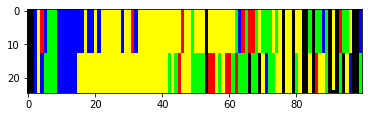

In [66]:
plt.imshow(out[0])

In [ ]:
def plot_loss_acc(lss, lss_t):
    fig,ax = plt.subplots()
    ax.plot(lss, label="train loss")
    ax.plot(lss_t, label = "test loss")
    #ax1 = ax.twinx()
    #ax1.plot(yacc, label = "train accuracy", ls='--')
    #ax1.plot(yacc_t, label = "test accuracy", ls='--')

    lines, labels = ax.get_legend_handles_labels()
    #lines2, labels2 = ax1.get_legend_handles_labels()

    ax.legend(lines, labels)

In [ ]:
plot_loss_acc(lss, lss_t)

In [ ]:
plot_loss_acc(lss3, lss_t3, yacc3, yacc_t3)

In [ ]:
def plot_change_latent_var(diva, lat_space="y", var_idx=[0,1,2,3,4,5,6,7], step = 5):
    a = next(enumerate(test_loader))
    with torch.no_grad():
        diva.eval()
        d = a[1][2][:len(var_idx)].to(DEVICE).float()
        x = a[1][0][:len(var_idx)].to(DEVICE).float()
        y = a[1][1][:len(var_idx)].to(DEVICE).float()

        zx, zx_sc = diva.qzx(x)
        zy, zy_sc = diva.qzy(x)
        zd, zd_sc =  diva.qzd(x)

        print(torch.max(zy), torch.min(zy), "sdmax:", torch.max(zy_sc))

        out = change(zx, zy, zd, var_idx, lat_space, diva, step)
    
    fig, ax = plt.subplots(ncols=out.shape[0],nrows=len(var_idx),figsize=(10*4*out.shape[0],10*len(var_idx)))
    for i in range(out.shape[0]):
      for j in range(len(var_idx)):
        ax[j,i].imshow(out[i,j])

In [ ]:
def change(zx, zy, zd, idx, lat = "y", model=diva, step = 2):
    
    dif = np.arange(-30,15,step)
    print(torch.max(zy), torch.min(zy))
    out = np.zeros((dif.shape[0], len(idx), 25, 100 ,3))  
    #print(zy.shape, dif.shape[0])
    for i in range(dif.shape[0]):
      for j in range(len(idx)):
        if lat == "y":
            zy[j,idx] = dif[i]
        elif lat == "x":
            zx[j,idx] = dif[i]
        elif lat == "d":
            zd[j,idx] = dif[i]
        len_, bar, col = model.px(zd[j],zx[j],zy[j])
        out[i,j] = model.px.reconstruct_image(len_[None,:], bar, col)
    
    return out



In [ ]:
plot_change_latent_var(diva)

In [ ]:
fig,ax = plt.subplots()
ax.plot(np.arange(50,120), [i.cpu().detach().numpy() for i in lss2], label="train loss")
ax.plot(np.arange(50,120), [i.cpu().detach().numpy() for i in lss_t2], label = "testloss")
ax1 = ax.twinx()
ax1.plot(np.arange(50,120), yacc2, label = "train")
ax1.plot(np.arange(50,120), yacc_t2, label = "test")

plt.legend()

In [ ]:
fig,ax = plt.subplots()
ax.plot(np.arange(120,180), [i.cpu().detach().numpy() for i in lss3], label="train loss")
ax.plot(np.arange(120,180), [i.cpu().detach().numpy() for i in lss_t3], label = "testloss")
ax1 = ax.twinx()
ax1.plot(np.arange(120,180), yacc3, label = "train",c='green')
ax1.plot(np.arange(120,180), yacc_t3, label = "test")

plt.legend()

# Model Evaluation

## Sampling from trained model

In [ ]:
def plot_latent_space(lat_space="y"):
    '''
    lat_space: y, d, x
    '''

    

In [ ]:
plot(x, out, 0)

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3)
for i in range(9):
  ax[i//3, i%3].imshow(x[i].cpu().permute(1,2,0))
  
plt.savefig('divastamporg.png')